# **Talking Data Mobile User Demographics**

The purpose of this product is to classify population depending on their uses of their phone and phone brands. This classification is the first step to tailor advertising campaigns by third parties based on the usage of the mobile according to the age and gender of the population. For this we have a sample of the population using Mobile Talk data in China. Although this product has been developed for the Chinese population, it can be used globally as further research has shown that other mobile operators in other countries have access to the same type of data.

The purpose of this task is to build a model predicting users’ demographic characteristics based on their app usage, geolocation, and mobile device properties. Doing so will help millions of developers and brand advertisers around the world pursue data-driven marketing efforts which are relevant to their users and catered to their preferences.

**Target: gender_age group (M18_25, M26_35, M36_42, etc., F18_25, F26_35, etc.)**

Dataset Link : https://www.kaggle.com/c/talkingdata-mobile-user-demographics

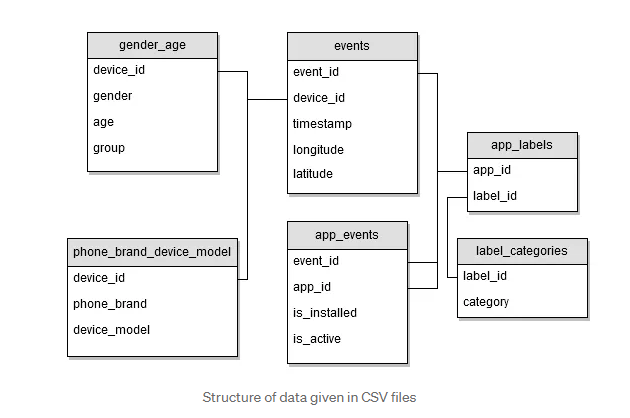

As part of this capstone, we are going to perform below models

Deep Learning Models:

*   Artificial Neural Network(ANN)
*   Convolutional Neural Network (CNN)

Supervised Models: (based on Kbest and PCA feature Selection approach)

*   Logistic Classification
*   KNN Classification
*   Decision Tree
*   Support Vector Classification
*   Random Forest

UnSupervised Models:

*   KMeans Clustering with PCA feature selection
*   GMM Clustering with t-SNE feature selection

# **1.Data Load**

In [2]:
#Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import statsmodels.api as sm
import matplotlib.pyplot as plt
from keras.layers import SimpleRNN, Dense
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score,KFold, cross_val_predict, GridSearchCV, StratifiedKFold
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.feature_selection import chi2, f_regression, SelectKBest
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, mean_absolute_error, classification_report
from sklearn import preprocessing, svm
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from google.colab import drive
from sklearn.cluster import KMeans
from sklearn import metrics
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

kf = KFold(5)

import warnings
warnings.filterwarnings('ignore')


In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Loading all the datasets
gatrain = pd.read_csv("/content/drive/MyDrive/Thinkful - Datascience/gender_age_train.csv")
gatest = pd.read_csv("/content/drive/MyDrive/Thinkful - Datascience/gender_age_test.csv")
phone = pd.read_csv("/content/drive/MyDrive/Thinkful - Datascience/phone_brand_device_model.csv")
app_events = pd.read_csv("/content/drive/MyDrive/Thinkful - Datascience/app_events.csv")
app_labels = pd.read_csv("/content/drive/MyDrive/Thinkful - Datascience/app_labels.csv")
labels_categories = pd.read_csv("/content/drive/MyDrive/Thinkful - Datascience/label_categories.csv")
events = pd.read_csv("/content/drive/MyDrive/Thinkful - Datascience/events.csv")

# **2.Exploratory Data Analysis (EDA)**

In [5]:
#Removing the duplicates
phone = phone.drop_duplicates('device_id',keep='first')

Checking the samples of all datasets

In [6]:
#gatrain dataset sample
print ("gatrain dataset")
gatrain.head()

gatrain dataset


,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38
3,-4938849341048082022,M,30,M29-31
4,245133531816851882,M,30,M29-31


In [7]:
#gatest dataset sample
print ("gatest dataset")
gatest.head()

gatest dataset


,device_id
0,1002079943728939269
1,-1547860181818787117
2,7374582448058474277
3,-6220210354783429585
4,-5893464122623104785


In [8]:
#phone dataset sample
print ("phone dataset")
phone.head()

phone dataset


,device_id,phone_brand,device_model
0,-8890648629457979026,小米,红米
1,1277779817574759137,小米,MI 2
2,5137427614288105724,三星,Galaxy S4
3,3669464369358936369,SUGAR,时尚手机
4,-5019277647504317457,三星,Galaxy Note 2


In [9]:
#app events dataset sample
print("app_events dataset")
app_events.head()

app_events dataset


,event_id,app_id,is_installed,is_active
0,2,5927333115845830913,1,1
1,2,-5720078949152207372,1,0
2,2,-1633887856876571208,1,0
3,2,-653184325010919369,1,1
4,2,8693964245073640147,1,1


In [10]:
#app labels dataset sample
print("app_labels dataset")
app_labels.head()

app_labels dataset


,app_id,label_id
0,7324884708820027918,251
1,-4494216993218550286,251
2,6058196446775239644,406
3,6058196446775239644,407
4,8694625920731541625,406


In [11]:
#events dataset sample
print("events dataset")
events.head()

events dataset


,event_id,device_id,timestamp,longitude,latitude
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70
3,4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28
4,5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66


In [12]:
#Merge the app_events and events to acorss app_ids.
device_apps = (

     app_events

     # Merge on event_id
    .merge(events, how = 'left', left_on = 'event_id', right_on = 'event_id')

     # remove the event_id
    .drop('event_id', axis = 1)

     # Because the events correspond to more than just
     # being installed, there are many duplicates
    .drop_duplicates())
device_apps.head()

,app_id,is_installed,is_active,device_id,timestamp,longitude,latitude
0,5927333115845830913,1,1,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
1,-5720078949152207372,1,0,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
2,-1633887856876571208,1,0,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
3,-653184325010919369,1,1,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
4,8693964245073640147,1,1,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97


In [13]:
#Merge the device_apps and app_lables to acorss app_ids.
apps = (
    device_apps

     # Merge on event_id
    .merge(app_labels, how = 'left', left_on = 'app_id', right_on = 'app_id')

     # remove app_id
    .drop('app_id', axis = 1)

     # Because the events correspond to more than just
     # being installed, there are many duplicates
    .drop_duplicates())

In [14]:
#drop 'na' values
apps.dropna()
#convert first or second to str or int
apps['device_id'] = apps['device_id'].astype(int)

#Merge the column back into the dataset
gatrain['device_id'] = gatrain['device_id'].astype(int)
apps.head()

,is_installed,is_active,device_id,timestamp,longitude,latitude,label_id
0,1,1,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97,549
1,1,1,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97,710
2,1,1,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97,704
3,1,1,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97,548
4,1,1,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97,172


In [15]:
#cheking the dataset type
apps.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74060117 entries, 0 to 207568941
Data columns (total 7 columns):
 #   Column        Dtype  
---  ------        -----  
 0   is_installed  int64  
 1   is_active     int64  
 2   device_id     int64  
 3   timestamp     object 
 4   longitude     float64
 5   latitude      float64
 6   label_id      int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 4.4+ GB


In [16]:
#Merge the apps and gatrain to acorss device_ids.
apps_with_groups = (
    apps

     # Merge on event_id
    .merge(gatrain, how = 'left', on = 'device_id')

     #.drop('device_id', axis = 1)

     # Because the events correspond to more than just
     # being installed, there are many duplicates
    .drop_duplicates())

In [17]:
#dropping 'na' values and resetting the index
apps_with_groups = apps_with_groups.dropna()
apps_with_groups.reset_index(drop= True)
apps_with_groups.head()

,is_installed,is_active,device_id,timestamp,longitude,latitude,label_id,gender,age,group
74,1,1,1476664663289716375,2016-05-01 00:27:21,0.0,0.0,549,M,19.0,M22-
75,1,1,1476664663289716375,2016-05-01 00:27:21,0.0,0.0,721,M,19.0,M22-
76,1,1,1476664663289716375,2016-05-01 00:27:21,0.0,0.0,704,M,19.0,M22-
77,1,1,1476664663289716375,2016-05-01 00:27:21,0.0,0.0,302,M,19.0,M22-
78,1,1,1476664663289716375,2016-05-01 00:27:21,0.0,0.0,303,M,19.0,M22-


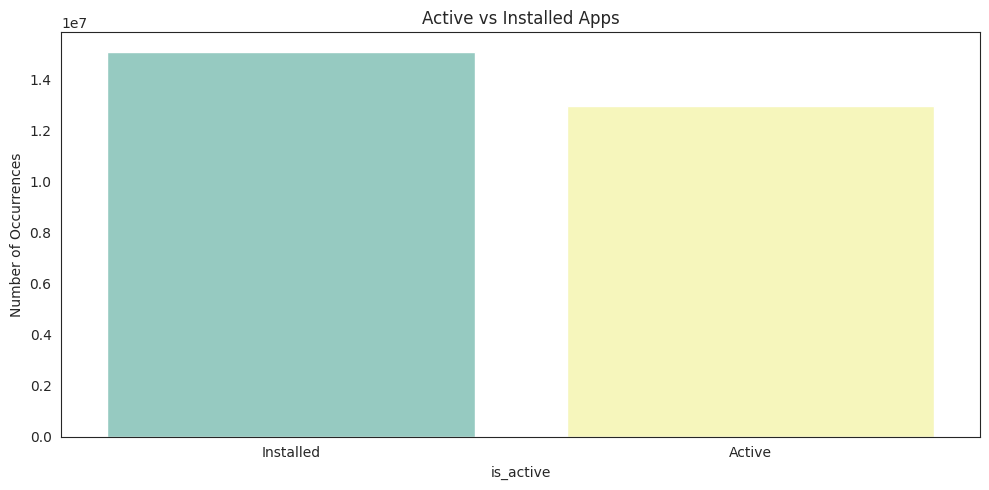

In [19]:
#Plot installed vs active apps

plt.figure(figsize=(10, 5))
sns.set_style("white")
ax = sns.countplot(x="is_active", data=apps_with_groups, palette="Set3")
ax.set_title('Active vs Installed Apps')
ax.set_ylabel('Number of Occurrences')
ax.set_xticklabels(['Installed','Active'], fontsize=10)
plt.tight_layout()
plt.show()

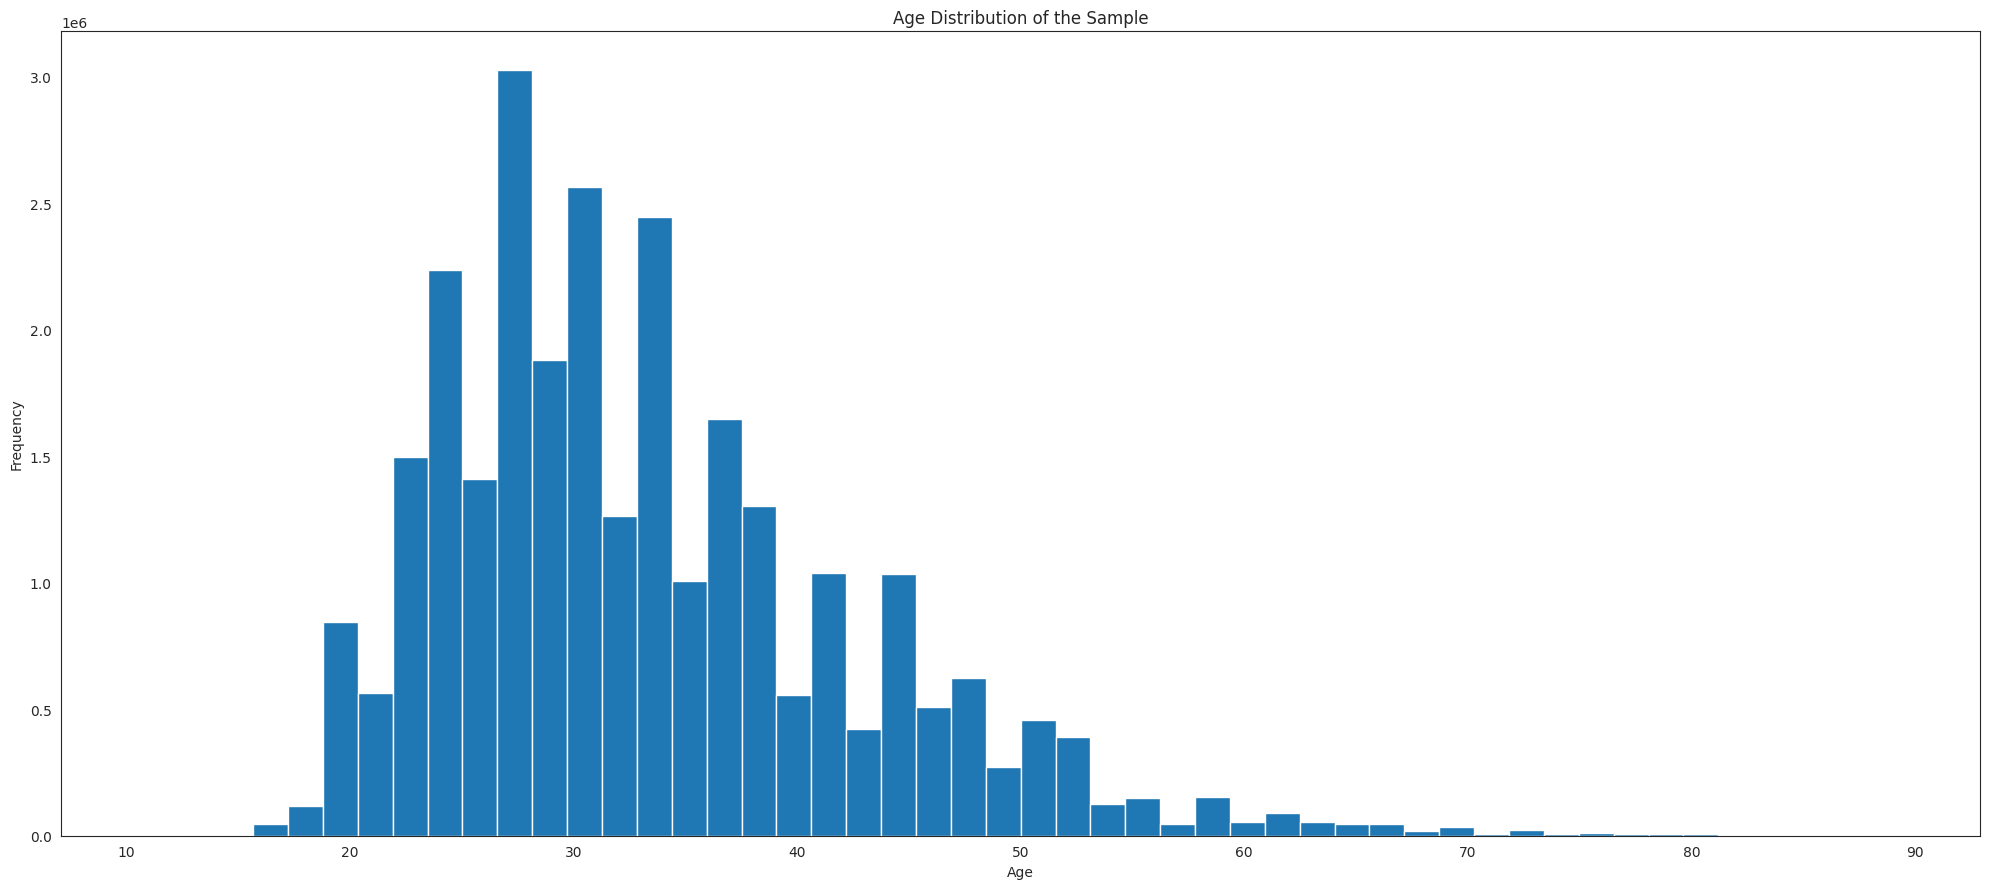

In [20]:
#Plot the distribution of age in the dataset

plt.figure(figsize=(20, 9))
apps_with_groups.age.hist(bins=50, grid = False)
plt.title('Age Distribution of the Sample')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

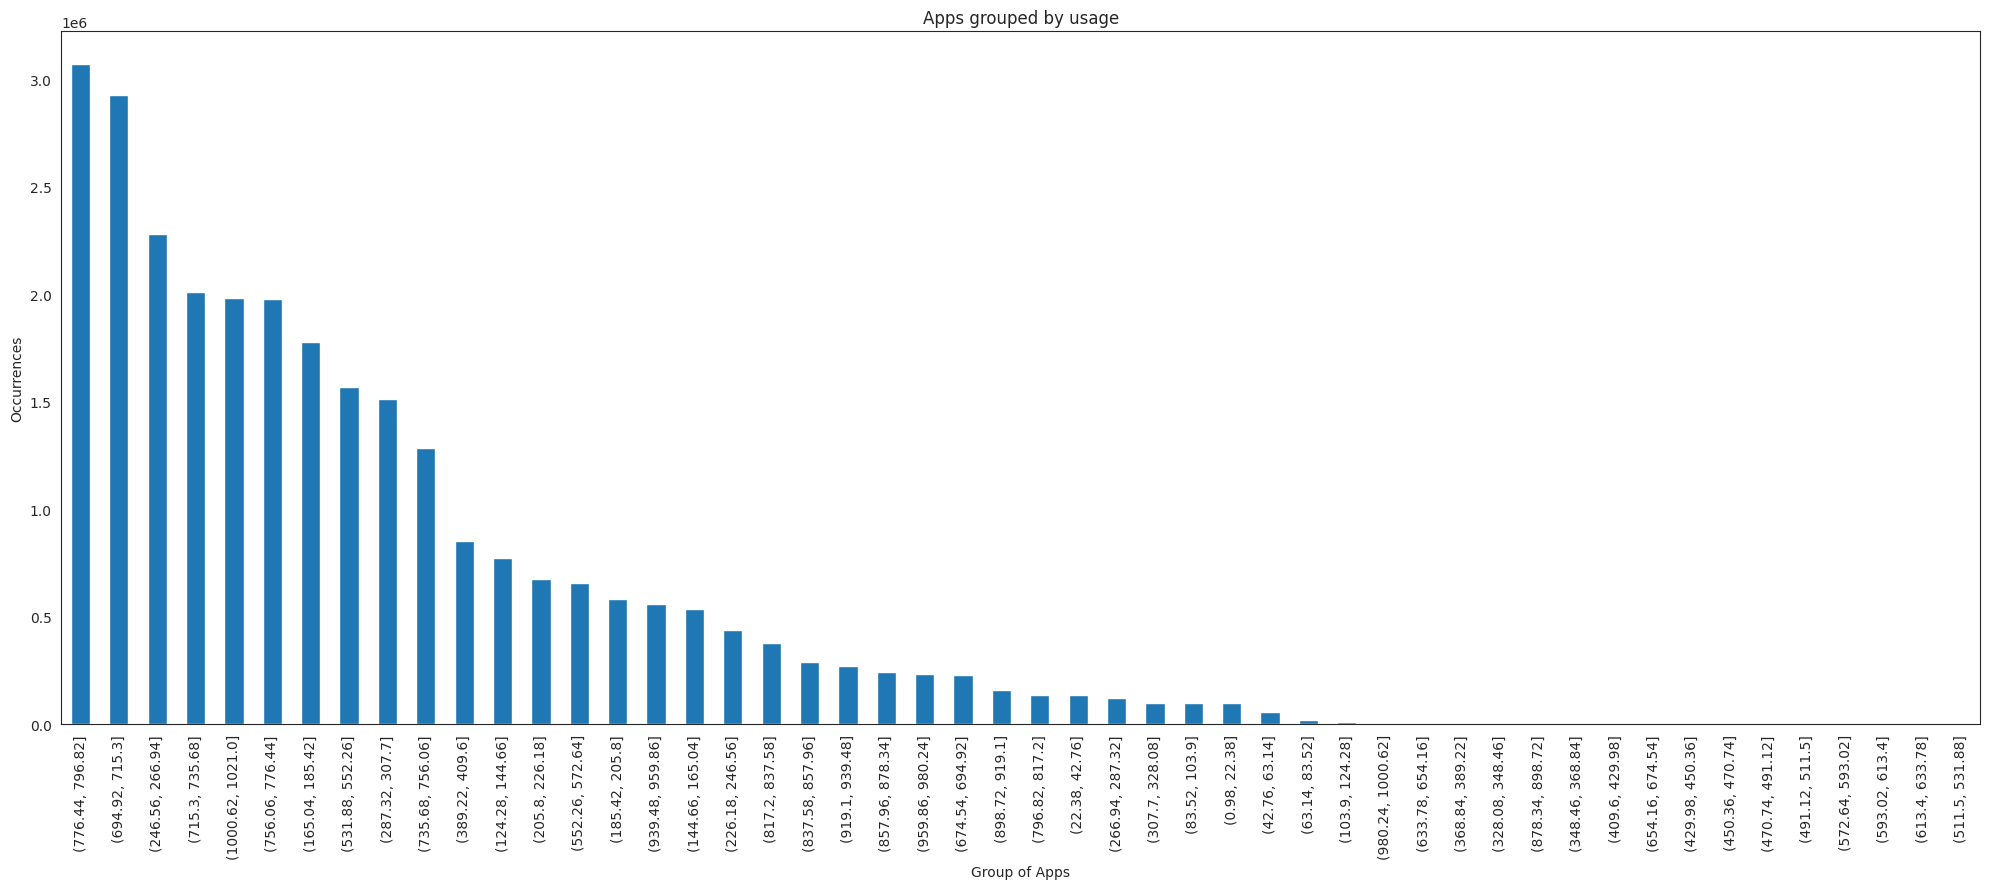

In [21]:
#Plot grouping the apps in different bins to understand its usage.
#Bins range from 10-50 for more detailed analysis

plt.figure(figsize=(20, 9))
apps_with_groups.label_id.value_counts(bins = 50).plot(kind='bar', grid=False)
plt.title('Apps grouped by usage')
plt.xlabel('Group of Apps')
plt.ylabel('Occurrences')
plt.tight_layout()
plt.show()

In [ ]:
#Create dummy variables for the categories found in the apps
dataset_with_dummy_variables = pd.get_dummies(apps_with_groups, columns = ['label_id'], sparse = True).reset_index(drop= True)

#Print the first 5 rows of data
dataset_with_dummy_variables.head()

,is_installed,is_active,device_id,timestamp,longitude,latitude,gender,age,group,label_id_2,...,label_id_1012,label_id_1013,label_id_1014,label_id_1015,label_id_1016,label_id_1017,label_id_1018,label_id_1019,label_id_1020,label_id_1021
0,1,1,1476664663289716375,2016-05-01 00:27:21,0.0,0.0,M,19.0,M22-,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1476664663289716375,2016-05-01 00:27:21,0.0,0.0,M,19.0,M22-,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1476664663289716375,2016-05-01 00:27:21,0.0,0.0,M,19.0,M22-,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1476664663289716375,2016-05-01 00:27:21,0.0,0.0,M,19.0,M22-,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1476664663289716375,2016-05-01 00:27:21,0.0,0.0,M,19.0,M22-,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#Add a brand name "UBXX" per brand in Chinese for which we don´t have a translation
english_phone_brands_mapping = {"三星": "samsung","天语": "Ktouch", "海信": "hisense", "联想": "lenovo", "欧比": "obi",
                                "爱派尔": "ipair", "努比亚": "nubia", "优米": "youmi", "朵唯": "dowe", "黑米": "heymi",
                                "锤子": "hammer", "酷比魔方": "koobee", "美图": "meitu", "尼比鲁": "nibilu", "一加": "oneplus",
                                "优购": "yougo", "诺基亚": "nokia", "糖葫芦": "candy", "中国移动": "ccmc", "语信": "yuxin",
                                "基伍": "kiwu", "青橙": "greeno", "华硕": "asus", "夏新": "panasonic", "维图": "weitu",
                                "艾优尼": "aiyouni", "摩托罗拉": "moto", "乡米": "xiangmi", "米奇": "micky", "大可乐": "bigcola",
                                "沃普丰": "wpf", "神舟": "hasse", "摩乐": "mole", "飞秒": "fs", "米歌": "mige", "富可视": "fks",
                                "德赛": "desci", "梦米": "mengmi", "乐视": "lshi", "小杨树": "smallt", "纽曼": "newman",
                                "邦华": "banghua", "E派": "epai", "易派": "epai", "普耐尔": "pner", "欧新": "ouxin", "西米": "ximi",
                                "海尔": "haier", "波导": "bodao", "糯米": "nuomi", "唯米": "weimi", "酷珀": "kupo", "谷歌": "google",
                                "昂达": "ada", "聆韵": "lingyun", "小米": "Xiaomi", "华为": "Huawei", "魅族": "Meizu", "中兴": "ZTE",
                                "酷派": "Coolpad", "金立": "Gionee", "SUGAR": "SUGAR", "OPPO": "OPPO", "vivo": "vivo", "HTC": "HTC",
                                "LG": "LG", "ZUK": "ZUK", "TCL": "TCL", "LOGO": "LOGO", "SUGAR": "SUGAR", "Lovme": "Lovme",
                                "PPTV": "PPTV", "ZOYE": "ZOYE", "MIL": "MIL", "索尼" : "Sony", "欧博信" : "Opssom", "奇酷" : "Qiku",
                                "酷比" : "CUBE", "康佳" : "Konka", "亿通" : "Yitong", "金星数码" : "JXD", "至尊宝" : "Monkey King",
                                "百立丰" : "Hundred Li Feng", "贝尔丰" : "Bifer", "百加" : "Bacardi", "诺亚信" : "Noain",
                                "广信" : "Kingsun", "世纪天元" : "Ctyon", "青葱" : "Cong", "果米" : "Taobao", "斐讯" : "Phicomm",
                                "长虹" : "Changhong", "欧奇" : "Oukimobile", "先锋" : "XFPLAY", "台电" : "Teclast", "大Q" : "Daq",
                                "蓝魔" : "Ramos", "奥克斯" : "AUX", "索尼" : "Sony", "欧博信" : "Opssom", "奇酷" : "Qiku",
                                "酷比" : "CUBE", "康佳" : "Konka", "亿通" : "Yitong", "金星数码" : "JXD", "至尊宝" : "Monkey King",
                                "百立丰" : "Hundred Li Feng", "贝尔丰" : "Bifer", "百加" : "Bacardi", "诺亚信" : "Noain",
                                "广信" : "Kingsun", "世纪天元" : "Ctyon", "青葱" : "Cong", "果米" : "Taobao", "斐讯" : "Phicomm",
                                "长虹" : "Changhong", "欧奇" : "Oukimobile", "先锋" : "XFPLAY", "台电" : "Teclast", "大Q" : "Daq",
                                "蓝魔" : "Ramos", "奥克斯" : "AUX", "飞利浦": "Philips", "智镁": "Zhimei", "惠普": "HP",
                                "原点": "Origin", "戴尔": "Dell", "碟米": "Diemi", "西门子": "Siemens", "亚马逊": "Amazon",
                                "宏碁": "Acer",
                                '世纪星': "UB1", '丰米': "UB2", '优语':'UB3', '凯利通': "UB4", '唯比': "UB5", '嘉源': "UB6",
                                 '大显': "UB7", '天宏时代': "UB8", '宝捷讯': 'UB9','帷幄': 'UB10', '德卡诺': 'UB11',
                                '恒宇丰': 'UB12', '本为': 'UB13', '极米': 'UB14', '欧乐迪': 'UB15', '欧乐酷': 'UB16',
                                '欧沃': 'UB17', '瑞米': 'UB18', '瑞高': 'UB19', '白米': 'UB20', '虾米': 'UB21', '赛博宇华': 'UB22',
                                '首云': 'UB23', '鲜米': 'UB24'}

In [ ]:
#Replace the brands in Chinese for the brands in English
phone['phone_brand'].replace(english_phone_brands_mapping, inplace=True)

#Drop the device model column as it is not adding information
phone = phone.drop('device_model',axis=1)

#Retreive information about the new dataset before getting the dummy variables
phone.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 186716 entries, 0 to 187243
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   device_id    186716 non-null  int64 
 1   phone_brand  186716 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.3+ MB


In [ ]:
#Build the dummy variables with the phone brand
phone_dummies = pd.get_dummies(phone, columns = ['phone_brand'], sparse = True).reset_index(drop= True)

In [ ]:
#Merge the dataset_with_dummy_variables and phone_dummies to acorss app_ids.
final_dataset = (
    dataset_with_dummy_variables

     # Merge on event_id
    .merge(phone_dummies, how = 'left', left_on = 'device_id', right_on = 'device_id')

     # event_id itself is not interesting
    .fillna(0))

In [ ]:
#Information about the dataset
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28068834 entries, 0 to 28068833
Columns: 624 entries, is_installed to phone_brand_yuxin
dtypes: Sparse[int64, 0](615), float64(3), int64(3), object(3)
memory usage: 2.7+ GB


In [ ]:
#Drop from the final dataset duplicates for the devices keeping the first one
final_dataset = final_dataset.drop_duplicates('device_id',keep= 'first').reset_index(drop=True)

#Get infomation of the new dataset to see the rows that have been eliminated
print(final_dataset.info())

#Print the first five rows of the dataset
final_dataset.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23290 entries, 0 to 23289
Columns: 624 entries, is_installed to phone_brand_yuxin
dtypes: Sparse[int64, 0](615), float64(3), int64(3), object(3)
memory usage: 2.1+ MB
None


,is_installed,is_active,device_id,timestamp,longitude,latitude,gender,age,group,label_id_2,...,phone_brand_smallt,phone_brand_vivo,phone_brand_weimi,phone_brand_weitu,phone_brand_wpf,phone_brand_xiangmi,phone_brand_ximi,phone_brand_yougo,phone_brand_youmi,phone_brand_yuxin
0,1,1,1476664663289716375,2016-05-01 00:27:21,0.00,0.00,M,19.0,M22-,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,7166563712658305181,2016-05-01 00:31:40,117.96,28.47,M,60.0,M39+,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,-3449419341168524142,2016-05-01 00:25:41,0.00,0.00,M,28.0,M27-28,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,-6542093539413689868,2016-05-01 00:20:11,0.00,0.00,M,26.0,M23-26,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,-5638521260975573107,2016-05-01 00:19:59,0.00,0.00,M,22.0,M22-,0,...,0,0,0,0,0,0,0,0,0,0


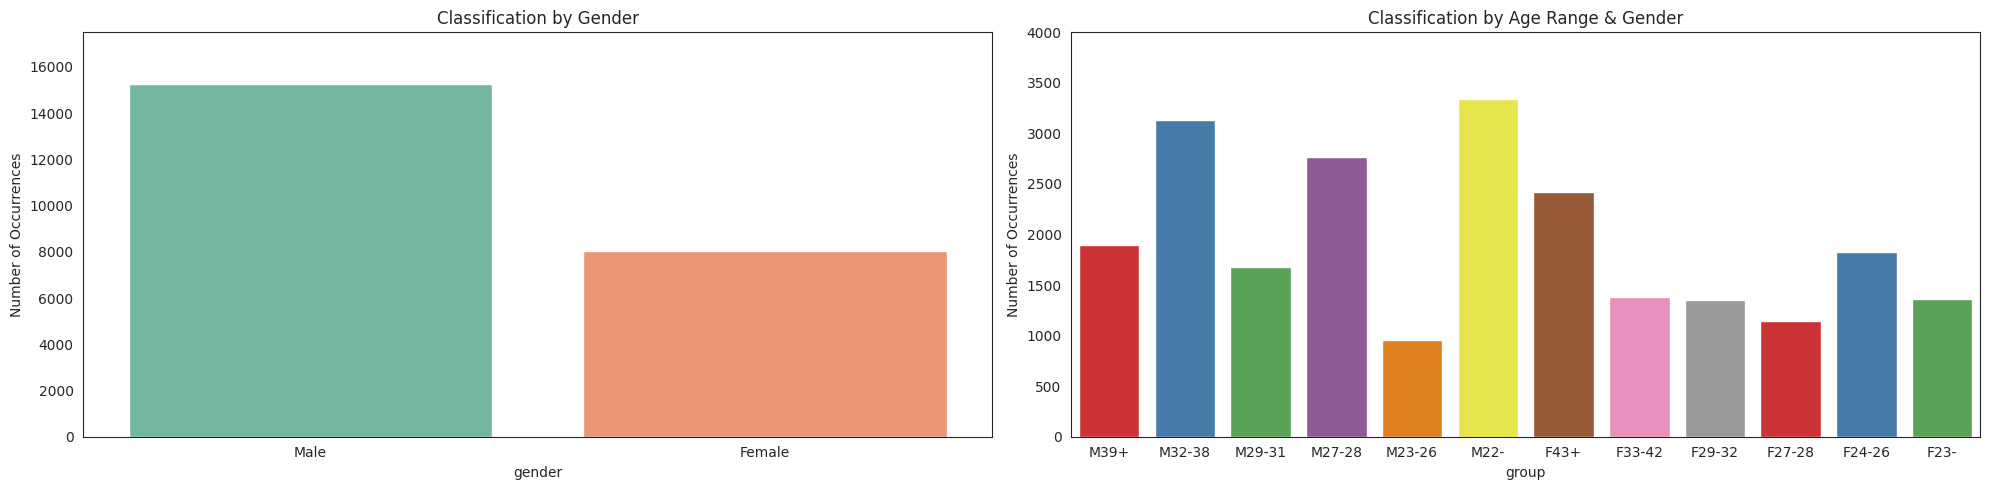

M32-38    3338
M39+      3137
M23-26    2770
M29-31    2423
M22-      1901
F33-42    1832
M27-28    1682
F29-32    1387
F23-      1365
F43+      1357
F24-26    1140
F27-28     958
Name: group, dtype: int64


In [ ]:
#Visualize the number of answers by Gender and by Category

plt.figure(figsize=(20, 5))
sns.set_style("white")

plt.subplot(1, 2, 1)
ax = sns.countplot(x="gender", data=final_dataset, palette="Set2")
ax.set_title('Classification by Gender')
ax.set_ylabel('Number of Occurrences')
ax.set_xticklabels(['Male','Female'], fontsize=10)
plt.ylim(0, 17500)

plt.subplot(1, 2, 2)
ax = sns.countplot(x="group", data=final_dataset, palette="Set1")
ax.set_title('Classification by Age Range & Gender')
ax.set_ylabel('Number of Occurrences')
ax.set_xticklabels(['M39+','M32-38', 'M29-31', 'M27-28', 'M23-26','M22-','F43+','F33-42', 'F29-32', 'F27-28', 'F24-26', 'F23-'], fontsize=10)
plt.ylim(0, 4000)

plt.tight_layout()
plt.show()

#Count number of datapoints for each group to resample all of them.
print(final_dataset['group'].value_counts())

In [ ]:
from sklearn.utils import resample

#Upsample minority classes
# Separate majority and minority classes
final_dataset_majority = final_dataset[final_dataset.group=='M32-38']

#Minorty classes
final_dataset_minority_1 = final_dataset[final_dataset.group=='M39+']
final_dataset_minority_2 = final_dataset[final_dataset.group=='M23-26']
final_dataset_minority_3 = final_dataset[final_dataset.group=='M29-31']
final_dataset_minority_4 = final_dataset[final_dataset.group=='M22-']
final_dataset_minority_5 = final_dataset[final_dataset.group=='F33-42']
final_dataset_minority_6 = final_dataset[final_dataset.group=='M27-28']
final_dataset_minority_7 = final_dataset[final_dataset.group=='F29-32']
final_dataset_minority_8 = final_dataset[final_dataset.group=='F23-']
final_dataset_minority_9 = final_dataset[final_dataset.group=='F43+']
final_dataset_minority_10 = final_dataset[final_dataset.group=='F24-26']
final_dataset_minority_11 = final_dataset[final_dataset.group=='F27-28']


# Upsample airlines minorities
final_dataset_upsampled_1 = resample(final_dataset_minority_1, replace=True, n_samples=3338, random_state=123)
final_dataset_upsampled_2 = resample(final_dataset_minority_2, replace=True, n_samples=3338, random_state=123)
final_dataset_upsampled_3 = resample(final_dataset_minority_3, replace=True, n_samples=3338, random_state=123)
final_dataset_upsampled_4 = resample(final_dataset_minority_4, replace=True, n_samples=3338, random_state=123)
final_dataset_upsampled_5 = resample(final_dataset_minority_5, replace=True, n_samples=3338, random_state=123)
final_dataset_upsampled_6 = resample(final_dataset_minority_6, replace=True, n_samples=3338, random_state=123)
final_dataset_upsampled_7 = resample(final_dataset_minority_7, replace=True, n_samples=3338, random_state=123)
final_dataset_upsampled_8 = resample(final_dataset_minority_8, replace=True, n_samples=3338, random_state=123)
final_dataset_upsampled_9 = resample(final_dataset_minority_9, replace=True, n_samples=3338, random_state=123)
final_dataset_upsampled_10 = resample(final_dataset_minority_10, replace=True, n_samples=3338, random_state=123)
final_dataset_upsampled_11 = resample(final_dataset_minority_11, replace=True, n_samples=3338, random_state=123)

# Combine majority class with upsampled minority classes
final_dataset_upsampled = pd.concat([final_dataset_majority, final_dataset_upsampled_1, final_dataset_upsampled_2,
                                  final_dataset_upsampled_3, final_dataset_upsampled_4, final_dataset_upsampled_5,
                                  final_dataset_upsampled_6, final_dataset_upsampled_7, final_dataset_upsampled_8,
                                  final_dataset_upsampled_9, final_dataset_upsampled_10, final_dataset_upsampled_11])
# Display new class counts
final_dataset_upsampled.group.value_counts()

M32-38    3338
M39+      3338
M23-26    3338
M29-31    3338
M22-      3338
F33-42    3338
M27-28    3338
F29-32    3338
F23-      3338
F43+      3338
F24-26    3338
F27-28    3338
Name: group, dtype: int64

In [ ]:

#Get dummy variables for the gender variable and reset index
clean_final_dataset = pd.get_dummies(final_dataset_upsampled, columns = ['gender'], sparse = True,).reset_index(drop= True)

#Delete column with device_id
clean_final_dataset = clean_final_dataset.drop('device_id', axis = 1)

#Delete columns that are all zeros
clean_final_dataset = clean_final_dataset.drop(clean_final_dataset.columns[(clean_final_dataset == 0).all()], axis = 1)

#Substitute the categorical output variable
clean_final_dataset['group'] = clean_final_dataset['group'].map({'M39+' :0,'M32-38':1, 'M29-31':2, 'M27-28':3, 'M23-26':4,'M22-': 5,
                                           'F43+' :6,'F33-42':7, 'F29-32':8, 'F27-28':9, 'F24-26':10, 'F23-':11 })

#Print the first five rows of the new dataset
clean_final_dataset.head()

,is_installed,is_active,timestamp,longitude,latitude,age,group,label_id_6,label_id_8,label_id_10,...,phone_brand_weimi,phone_brand_weitu,phone_brand_wpf,phone_brand_xiangmi,phone_brand_ximi,phone_brand_yougo,phone_brand_youmi,phone_brand_yuxin,gender_F,gender_M
0,1,1,2016-05-01 00:27:30,0.00,0.00,35.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,0,2016-05-01 00:19:15,116.34,39.77,34.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,0,2016-05-02 00:17:01,0.00,0.00,36.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,1,0,2016-05-02 00:11:10,0.00,0.00,35.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,0,2016-05-02 00:37:31,0.00,0.00,33.0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
#Drop unwanted columns
clean_final_dataset.drop(['is_installed','timestamp','latitude','longitude'],inplace=True,axis=1)

In [ ]:
#Print the first five rows of the new dataset
clean_final_dataset.head()

,is_active,age,group,label_id_6,label_id_8,label_id_10,label_id_11,label_id_12,label_id_13,label_id_14,...,phone_brand_weimi,phone_brand_weitu,phone_brand_wpf,phone_brand_xiangmi,phone_brand_ximi,phone_brand_yougo,phone_brand_youmi,phone_brand_yuxin,gender_F,gender_M
0,1,35.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,34.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,36.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,35.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,33.0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [ ]:
#Defining the X and y
from sklearn.preprocessing import normalize

#Build the predictors and output variables
X = clean_final_dataset.drop('group',axis = 1)
y = clean_final_dataset.group

#Preprocess and scale data
names = X.columns
X_processed = pd.DataFrame(normalize(preprocessing.scale(X)), columns = names)



In [ ]:
#Check shape of X_processed and y
print(X_processed.shape, y.shape)

#Print the groups in y
print(y.unique())

(40056, 273) (40056,)
[ 1  0  4  2  5  7  3  8 11  6 10  9]


In [ ]:
#Split the dataset into a training and testing dataset 70/30
X_train, X_test, y_train, y_test = train_test_split(X_processed, y,test_size=0.3, random_state=42)

# **3.Deep Learning Classification**

**Artificial Neural Network (ANN) Model**

In [ ]:
#Check the shapes of all X and y
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((28039, 273), (12017, 273), (28039,), (12017,))

In [ ]:
#One-hot code your target variable using the to_categorical() function from the keras.utils module
from tensorflow.keras.utils import to_categorical
y_train_mlp = to_categorical(y_train, num_classes=12)
y_test_mlp = to_categorical(y_test, num_classes=12)
x_test_mlp = to_categorical(X_test, num_classes=12)
x_train_mlp = to_categorical(X_train, num_classes=12)

print(y_train_mlp.shape, y_test_mlp.shape,x_test_mlp.shape, x_train_mlp.shape)

(28039, 12) (12017, 12) (12017, 273, 12) (28039, 273, 12)


In [ ]:
#ANN Sequential Model
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

#Start the model
model = Sequential()

#Set up the outter layer
model.add(Dense(264, activation='relu', input_dim=273))

# Dropout layers remove features and fight overfitting

model.add(Dense(264, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

# End with a number of units equal to the number of classes we have for our outcome
model.add(Dense(12, activation='softmax'))

#Model features
model.summary()

# Compile the model to put it all together.
model.compile(loss='categorical_crossentropy',optimizer= 'sgd',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 264)               72336     
                                                                 
 dense_1 (Dense)             (None, 264)               69960     
                                                                 
 dense_2 (Dense)             (None, 128)               33920     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 12)                396       
                                                                 
Total params: 186948 (730.27 KB)
Trainable params: 18694

In [ ]:
#Run the ANN model
model.fit(X_train, y_train_mlp,
                   epochs=40,
                  verbose=1,
                   batch_size=128)

#Evaluate the model
score = model.evaluate(X_test, y_test_mlp, verbose=1)

#Print results
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/40
220/220 [==============================] - 1s 3ms/step - loss: 2.4819 - accuracy: 0.1214
Epoch 2/40
220/220 [==============================] - 1s 4ms/step - loss: 2.4778 - accuracy: 0.1283
Epoch 3/40
220/220 [==============================] - 1s 3ms/step - loss: 2.4727 - accuracy: 0.1516
Epoch 4/40
220/220 [==============================] - 1s 3ms/step - loss: 2.4647 - accuracy: 0.1749
Epoch 5/40
220/220 [==============================] - 1s 3ms/step - loss: 2.4515 - accuracy: 0.1935
Epoch 6/40
220/220 [==============================] - 1s 3ms/step - loss: 2.4269 - accuracy: 0.2025
Epoch 7/40
220/220 [==============================] - 1s 3ms/step - loss: 2.3744 - accuracy: 0.2060
Epoch 8/40
220/220 [==============================] - 1s 3ms/step - loss: 2.2538 - accuracy: 0.2184
Epoch 9/40
220/220 [==============================] - 1s 3ms/step - loss: 2.0340 - accuracy: 0.2463
Epoch 10/40
220/220 [==============================] - 1s 3ms/step - loss: 1.7589 - accuracy: 0.3156

In [ ]:
#Predict the model
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Compute accuracy score
accuracy = accuracy_score(y_test_mlp, y_pred_classes)
print("Accuracy:", accuracy)


# Generate classification report
report = classification_report(y_test_mlp, y_pred_classes)

# Print the report
print ("Classification Report")
print ("---------------------------------------------")
print(report)



376/376 [==============================] - 1s 2ms/step
Accuracy: 0.7832237663310311
Classification Report
---------------------------------------------
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      1017
           1       0.95      0.85      0.90      1036
           2       0.85      0.45      0.58       973
           3       0.56      0.66      0.61       994
           4       0.69      0.68      0.69      1015
           5       0.74      0.99      0.85       991
           6       1.00      0.84      0.91       991
           7       0.83      0.82      0.83       985
           8       0.81      0.74      0.78       980
           9       0.77      0.74      0.75       992
          10       0.74      0.68      0.71      1047
          11       0.74      1.00      0.85       996

   micro avg       0.79      0.78      0.79     12017
   macro avg       0.81      0.78      0.78     12017
weighted avg       0.81      0.78   

**Convolutional Neural Network (CNN)**

In [ ]:
#Convert the X_train to 3 dimension (No of rows, No of columns, No of single output row) for  CNN model
X_train_array = X_train.to_numpy()

# Reshape the array
X_train_resized = X_train_array.reshape(28039, 273,1)

# Print the resized array
print(X_train_resized)

[[[ 0.04672172]
  [-0.05008645]
  [-0.000477  ]
  ...
  [-0.00176989]
  [-0.04773107]
  [ 0.04773107]]

 [[ 0.13100031]
  [ 0.29522246]
  [-0.00133743]
  ...
  [-0.0049625 ]
  [-0.13383036]
  [ 0.13383036]]

 [[-0.32436888]
  [-0.07478107]
  [-0.00317303]
  ...
  [-0.01177342]
  [ 0.31750959]
  [-0.31750959]]

 ...

 [[-0.2700233 ]
  [-0.08914009]
  [-0.00264142]
  ...
  [-0.00980087]
  [ 0.26431324]
  [-0.26431324]]

 [[-0.04930271]
  [ 0.0328182 ]
  [-0.00048229]
  ...
  [-0.00178951]
  [-0.04826013]
  [ 0.04826013]]

 [[-0.24511206]
  [-0.27617598]
  [-0.00239773]
  ...
  [-0.00889669]
  [-0.23992879]
  [ 0.23992879]]]


In [ ]:
#Convert the X_test to 3 dimension (No of rows, No of columns, No of single output row) for RNN and CNN models
x_test_array = X_test.to_numpy()

# Reshape the array
x_test_resized = x_test_array.reshape(12017, 273,1)

# Print the resized array
print(x_test_resized)

[[[ 0.07370906]
  [-0.03305579]
  [-0.00075253]
  ...
  [-0.00279222]
  [-0.07530143]
  [ 0.07530143]]

 [[ 0.25681607]
  [-0.16855202]
  [-0.00262194]
  ...
  [-0.0097286 ]
  [-0.26236417]
  [ 0.26236417]]

 [[-0.13231868]
  [-0.0568569 ]
  [-0.00129436]
  ...
  [-0.00480269]
  [-0.12952059]
  [ 0.12952059]]

 ...

 [[ 0.24243274]
  [ 0.01725266]
  [-0.00247509]
  ...
  [-0.00918374]
  [ 0.24767011]
  [-0.24767011]]

 [[ 0.06400207]
  [ 0.25730979]
  [-0.00065342]
  ...
  [-0.0024245 ]
  [ 0.06538473]
  [-0.06538473]]

 [[-0.08990823]
  [-0.01177498]
  [-0.0008795 ]
  ...
  [-0.00326335]
  [ 0.08800698]
  [-0.08800698]]]


In [ ]:
# 1D convolutional sequential model
from keras.layers import Dense, Conv1D, Flatten
model_cnn = Sequential()
model_cnn.add(Conv1D(32, 2, activation="relu", input_shape=(273, 1)))
model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation="relu"))
model_cnn.add(Dense(1))
model_cnn.compile(loss="mse", optimizer="adam")

model_cnn.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 272, 32)           96        
                                                                 
 flatten_3 (Flatten)         (None, 8704)              0         
                                                                 
 dense_21 (Dense)            (None, 64)                557120    
                                                                 
 dense_22 (Dense)            (None, 1)                 65        
                                                                 
Total params: 557281 (2.13 MB)
Trainable params: 557281 (2.13 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the model
model_cnn.fit(X_train_resized, y_train, epochs=40, verbose=1, batch_size= 128)


Epoch 1/40
220/220 [==============================] - 3s 10ms/step - loss: 6.8403
Epoch 2/40
220/220 [==============================] - 2s 10ms/step - loss: 1.4492
Epoch 3/40
220/220 [==============================] - 2s 9ms/step - loss: 0.9406
Epoch 4/40
220/220 [==============================] - 2s 9ms/step - loss: 0.7489
Epoch 5/40
220/220 [==============================] - 2s 9ms/step - loss: 0.5839
Epoch 6/40
220/220 [==============================] - 2s 9ms/step - loss: 0.4938
Epoch 7/40
220/220 [==============================] - 2s 10ms/step - loss: 0.4107
Epoch 8/40
220/220 [==============================] - 2s 10ms/step - loss: 0.3689
Epoch 9/40
220/220 [==============================] - 2s 9ms/step - loss: 0.3375
Epoch 10/40
220/220 [==============================] - 2s 9ms/step - loss: 0.3065
Epoch 11/40
220/220 [==============================] - 2s 9ms/step - loss: 0.2814
Epoch 12/40
220/220 [==============================] - 2s 9ms/step - loss: 0.2535
Epoch 13/40
220/220 [

In [ ]:
#Predict the model
y_pred_cnn = model_cnn.predict(x_test_resized)
y_pred_classes_cnn = (y_pred_cnn ).astype("int32")

# Generate classification report
report = classification_report(y_test, y_pred_classes_cnn)

# Compute accuracy score
accuracy = accuracy_score(y_test, y_pred_classes_cnn)
print("Accuracy:", accuracy)

# Print the report
print ("Classification Report")
print ("---------------------------------------------")
print(report)

376/376 [==============================] - 1s 2ms/step
Accuracy: 0.48631105933261215
Classification Report
---------------------------------------------
              precision    recall  f1-score   support

           0       0.66      0.98      0.79      1017
           1       0.49      0.49      0.49      1036
           2       0.47      0.46      0.46       973
           3       0.41      0.51      0.45       994
           4       0.31      0.31      0.31      1015
           5       0.44      0.29      0.35       991
           6       0.61      0.64      0.62       991
           7       0.55      0.59      0.57       985
           8       0.50      0.51      0.51       980
           9       0.40      0.51      0.45       992
          10       0.30      0.28      0.29      1047
          11       1.00      0.28      0.44       996
          12       0.00      0.00      0.00         0

    accuracy                           0.49     12017
   macro avg       0.47      0.45  

Based on the accuracy of ANN and CNN models, ANN model performed better than CNN

*   **ANN Model Accuracy - 78.3%** (6 Dense Layers, Ranging from 264 t0 12 neurons, 40 epoch, 128 batch size,loss='categorical_crossentropy',optimizer= 'sgd')
*   **CNN Model Accuracy - 48.6%** (1 Convolutional layer, 1 Dense layer, 40 epoch, 128 batch size, loss="mse", optimizer="adam")



# **4.Unsupervised Learning**

**PCA Feature Decomposition**

In [ ]:
#Drop unwanted columns
uns_final_dataset = final_dataset.drop(['timestamp','latitude','longitude','device_id'], axis = 1)

In [ ]:
#Checking the dataset after dropping the columns
uns_final_dataset.head()

,is_installed,is_active,gender,age,group,label_id_2,label_id_4,label_id_6,label_id_7,label_id_8,...,phone_brand_smallt,phone_brand_vivo,phone_brand_weimi,phone_brand_weitu,phone_brand_wpf,phone_brand_xiangmi,phone_brand_ximi,phone_brand_yougo,phone_brand_youmi,phone_brand_yuxin
0,1,1,M,19.0,M22-,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,M,60.0,M39+,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,M,28.0,M27-28,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,M,26.0,M23-26,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,M,22.0,M22-,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
#One hot encoding for categorical columns
uns_final_dataset = pd.get_dummies(uns_final_dataset, columns = ['gender','age','group'], sparse = True).reset_index(drop= True)

In [ ]:
#Duplicate the dataset for further analysis
uns_final_dataset_copy = uns_final_dataset
uns_final_dataset_gmm = uns_final_dataset

In [ ]:
#Delete columns that are all zeros
uns_final_dataset = uns_final_dataset.drop(uns_final_dataset.columns[(uns_final_dataset == 0).all()], axis = 1)

#Print the first five rows of the new dataset
uns_final_dataset.head()



,is_installed,is_active,label_id_6,label_id_8,label_id_10,label_id_11,label_id_12,label_id_13,label_id_14,label_id_16,...,group_F27-28,group_F29-32,group_F33-42,group_F43+,group_M22-,group_M23-26,group_M27-28,group_M29-31,group_M32-38,group_M39+
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
# Standardize features by removing the mean and scaling to unit variance with sklearns StandardScaler.
scaler = StandardScaler()

# Fit scaler to data by calling fit_transform on our data.
X_scale = scaler.fit_transform(uns_final_dataset)

# Storing scaled data into new DataFrame.
df_scale = pd.DataFrame(X_scale, columns=uns_final_dataset.columns)
df_scale.head()

,is_installed,is_active,label_id_6,label_id_8,label_id_10,label_id_11,label_id_12,label_id_13,label_id_14,label_id_16,...,group_F27-28,group_F29-32,group_F33-42,group_F43+,group_M22-,group_M23-26,group_M27-28,group_M29-31,group_M32-38,group_M39+
0,0.0,1.000086,-0.009267,-0.021738,-0.006553,-0.035913,-0.01135,-0.027811,-0.01135,-0.020726,...,-0.207119,-0.251644,-0.292192,-0.248737,3.354318,-0.367410,-0.279001,-0.340759,-0.409025,-0.394537
1,0.0,1.000086,-0.009267,-0.021738,-0.006553,-0.035913,-0.01135,-0.027811,-0.01135,-0.020726,...,-0.207119,-0.251644,-0.292192,-0.248737,-0.298123,-0.367410,-0.279001,-0.340759,-0.409025,2.534618
2,0.0,1.000086,-0.009267,-0.021738,-0.006553,-0.035913,-0.01135,-0.027811,-0.01135,-0.020726,...,-0.207119,-0.251644,-0.292192,-0.248737,-0.298123,-0.367410,3.584217,-0.340759,-0.409025,-0.394537
3,0.0,1.000086,-0.009267,-0.021738,-0.006553,-0.035913,-0.01135,-0.027811,-0.01135,-0.020726,...,-0.207119,-0.251644,-0.292192,-0.248737,-0.298123,2.721754,-0.279001,-0.340759,-0.409025,-0.394537
4,0.0,1.000086,-0.009267,-0.021738,-0.006553,-0.035913,-0.01135,-0.027811,-0.01135,-0.020726,...,-0.207119,-0.251644,-0.292192,-0.248737,3.354318,-0.367410,-0.279001,-0.340759,-0.409025,-0.394537


In [ ]:
# PCA with the number of components set to 2, this will reduce our data to two dimensions.
pca = PCA(n_components=2)

# We get the components by calling fit_transform method with our data.
pca_components = pca.fit_transform(df_scale)

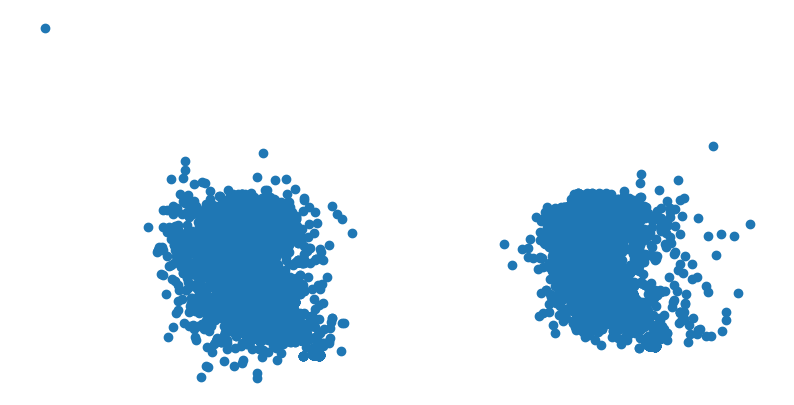

In [ ]:
# Defining pyplot figure size.
plt.figure(figsize=(10,5))

# Creating scatterplot of pca component dimensions with pyplot.
plt.scatter(pca_components[:, 0], pca_components[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

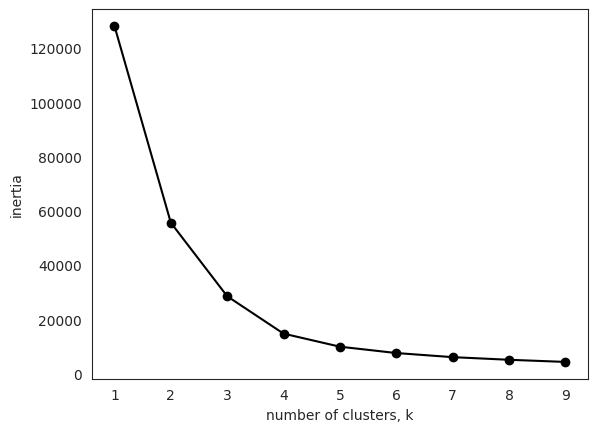

In [ ]:
# Components are now in Pandas DataFrame.
PCA_components = pd.DataFrame(pca_components)
# Create range of k values.
ks = range(1, 10)
inertias = []
for k in ks:
    # Create KMeans instance with k clusters: model.
    model = KMeans(n_clusters=k)

    # Fit model to samples.
    model.fit(PCA_components.iloc[:,:3])

    # Append the inertia to the list of inertias.
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

**Applying PCA to KMeans**

For Kmeans cluster number of 3
silhouette_score is 0.5870559020239619


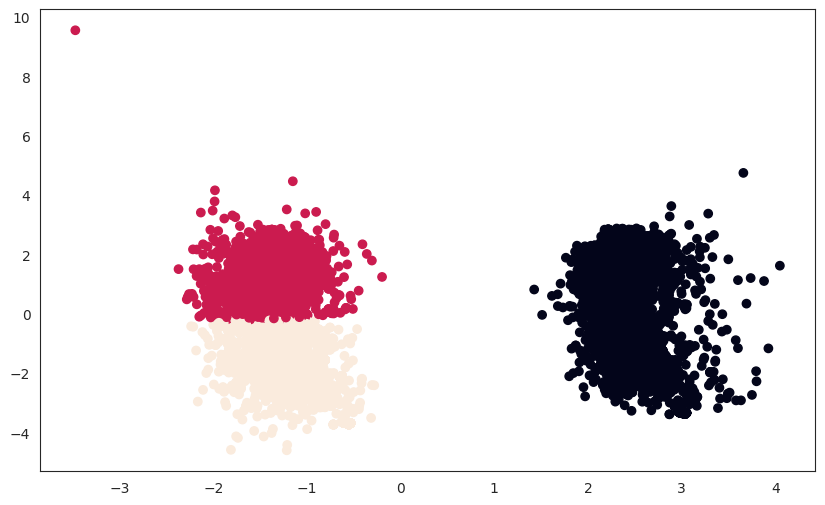

In [ ]:
#Finding the silhouette score based on KMeans cluster value '3'
kmeans  = KMeans(n_clusters=3, random_state=123).fit(PCA_components)
y_pred = kmeans.predict(PCA_components)

# Print silhouette score of KMeans.
print (f'For Kmeans cluster number of 3')
print("silhouette_score is",metrics.silhouette_score(PCA_components, kmeans.labels_, metric='euclidean'))
plt.figure(figsize=(10,6))
plt.scatter(PCA_components[0],PCA_components[1], c=y_pred);
plt.show()

For Kmeans cluster number of 4
silhouette_score is 0.6122913413046074


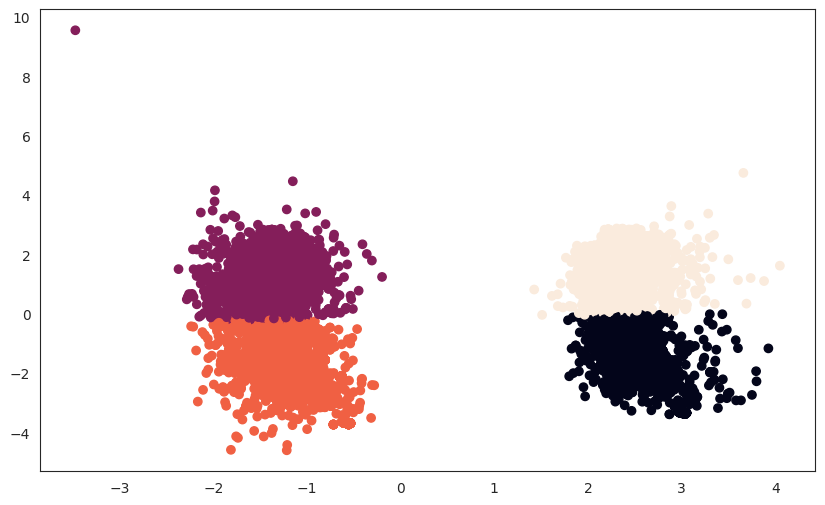

In [ ]:
#Finding the silhouette score based on KMeans cluster value '4'
kmeans  = KMeans(n_clusters=4, random_state=123).fit(PCA_components)
y_pred = kmeans.predict(PCA_components)

# Print silhouette score of KMeans.
print (f'For Kmeans cluster number of 4')
print("silhouette_score is",metrics.silhouette_score(PCA_components, kmeans.labels_, metric='euclidean'))
plt.figure(figsize=(10,6))
plt.scatter(PCA_components[0],PCA_components[1], c=y_pred);
plt.show()

For Kmeans cluster number of 5
silhouette_score is 0.5743752218128139


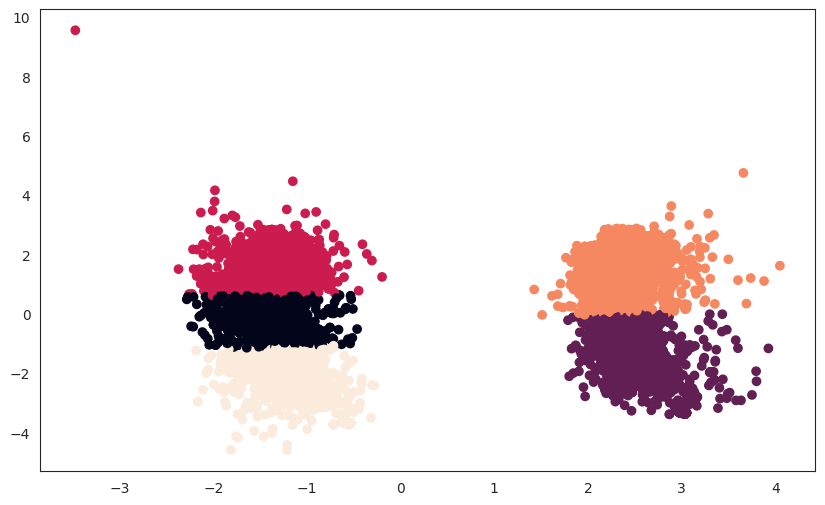

In [ ]:
#Finding the silhouette score based on KMeans cluster value '5'
kmeans  = KMeans(n_clusters=5, random_state=123).fit(PCA_components)
y_pred = kmeans.predict(PCA_components)

# Print silhouette score of KMeans.
print (f'For Kmeans cluster number of 5')
print("silhouette_score is",metrics.silhouette_score(PCA_components, kmeans.labels_, metric='euclidean'))
plt.figure(figsize=(10,6))
plt.scatter(PCA_components[0],PCA_components[1], c=y_pred);
plt.show()

In [ ]:
# Defining the k-means with the best silhouette value (4) and timing it.
kmeans_cluster = KMeans(n_clusters=4, random_state=123)
# Fitting and timing clustering.
%timeit kmeans_cluster.fit(PCA_components)
y_pred = kmeans_cluster.predict(PCA_components)

1.6 s ± 336 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


**Cluster Analysis of KMeans Clusters using PCA**

In [ ]:
#Adding the cluster info to the original dataset to do the analysis
uns_final_dataset_copy['clusters'] = kmeans_cluster.labels_
uns_final_dataset_copy['gender'] = final_dataset.gender
uns_final_dataset_copy['age'] = final_dataset.age
uns_final_dataset_copy['group'] = final_dataset.group

In [ ]:
#Checking the dataset after adding the additional columns
uns_final_dataset_copy.head()

,is_installed,is_active,label_id_2,label_id_4,label_id_6,label_id_7,label_id_8,label_id_9,label_id_10,label_id_11,...,group_M22-,group_M23-26,group_M27-28,group_M29-31,group_M32-38,group_M39+,clusters,gender,age,group
0,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,2,M,19.0,M22-
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,M,60.0,M39+
2,1,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,2,M,28.0,M27-28
3,1,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,2,M,26.0,M23-26
4,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,2,M,22.0,M22-


[Text(0, 0, '8314'),
 Text(0, 0, '6937'),
 Text(0, 0, '4396'),
 Text(0, 0, '3643')]

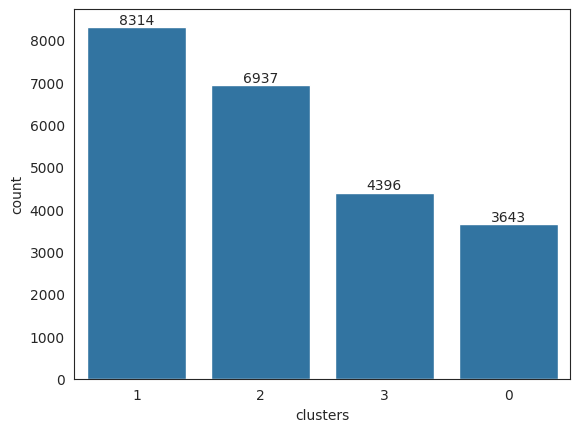

In [ ]:
#Finding the cluster which have more records
ax = sns.countplot(x=uns_final_dataset_copy['clusters'],
                   order=uns_final_dataset_copy['clusters'].value_counts(ascending=False).index);

abs_values = uns_final_dataset_copy['clusters'].value_counts(ascending=False).values

ax.bar_label(container=ax.containers[0], labels=abs_values)

During the time of execution, the Cluster 1 have more number of records

<Axes: xlabel='group', ylabel='count'>

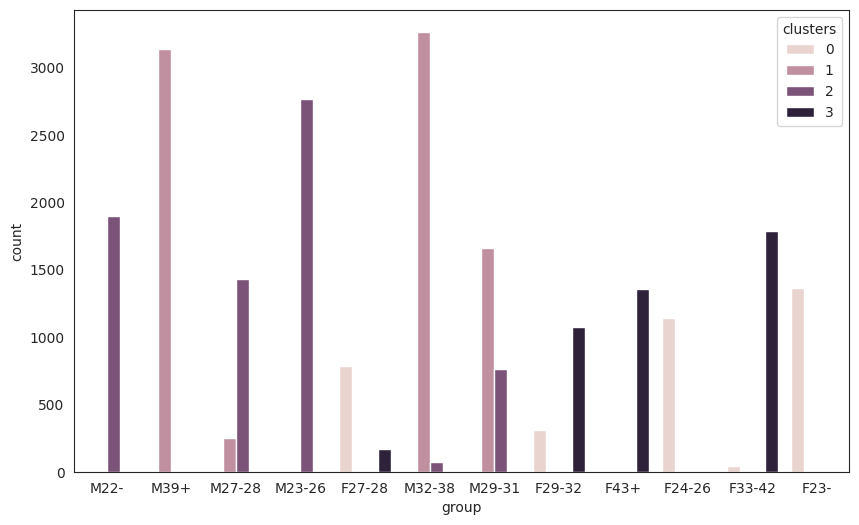

In [ ]:
#Finding the cluster which have most groups
plt.figure(figsize=(10,6))
sns.countplot(x ='group', data = uns_final_dataset_copy, hue= 'clusters')

During the time of execution,

*   the Cluster 0 have 'F27-F28', 'F29-32','F24-26','F33-42','F23-'. Only Female groups
*   the Cluster 1 have 'M39+', 'M32-38','M29-31','M29-31'. Only Male groups
*   the Cluster 2 have 'M22-', 'M27-28','M23-26','M29-31','M32-38' . Only Male groups
*   the Cluster 3 have 'F27-28', 'F29-32','F43+','F33-42 . Only Female groups



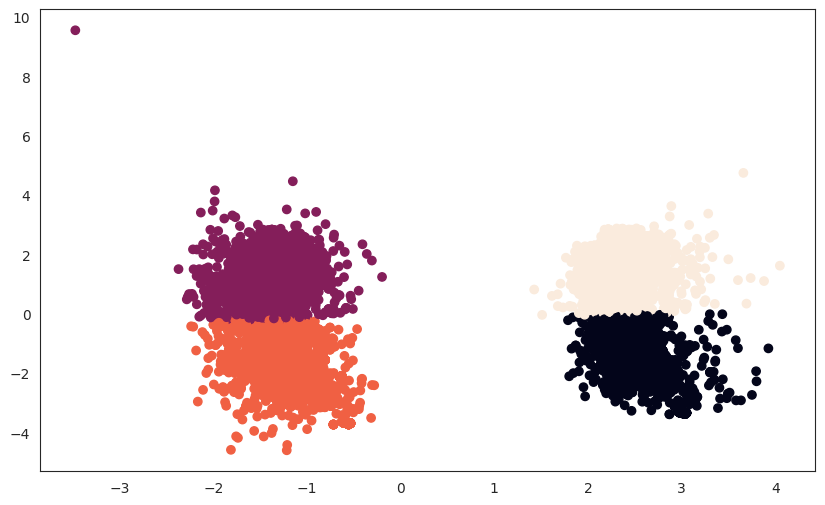

In [ ]:
#let's visualize the clusters formed by KMeans and PCA with a simple scatterplot.
plt.figure(figsize=(10,6))
plt.scatter(PCA_components[0],PCA_components[1], c=y_pred);
plt.show()

### **t-SNE Dimensionality Reduction**

perplexity is  90
[t-SNE] Computing 271 nearest neighbors...
[t-SNE] Indexed 23290 samples in 0.033s...
[t-SNE] Computed neighbors for 23290 samples in 4.424s...
[t-SNE] Computed conditional probabilities for sample 1000 / 23290
[t-SNE] Computed conditional probabilities for sample 2000 / 23290
[t-SNE] Computed conditional probabilities for sample 3000 / 23290
[t-SNE] Computed conditional probabilities for sample 4000 / 23290
[t-SNE] Computed conditional probabilities for sample 5000 / 23290
[t-SNE] Computed conditional probabilities for sample 6000 / 23290
[t-SNE] Computed conditional probabilities for sample 7000 / 23290
[t-SNE] Computed conditional probabilities for sample 8000 / 23290
[t-SNE] Computed conditional probabilities for sample 9000 / 23290
[t-SNE] Computed conditional probabilities for sample 10000 / 23290
[t-SNE] Computed conditional probabilities for sample 11000 / 23290
[t-SNE] Computed conditional probabilities for sample 12000 / 23290
[t-SNE] Computed conditional pr

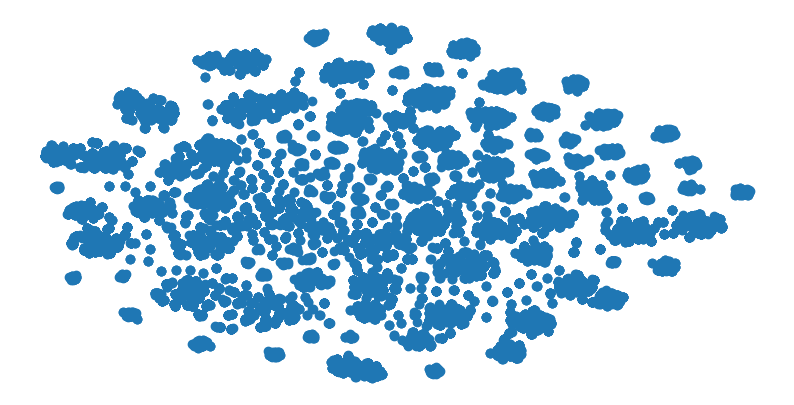

In [ ]:
#t-SNE Dimensionality Reduction with perplexity 90
import time
from sklearn.manifold import TSNE

perplexity = [90]

for i in perplexity:
    print ("perplexity is ",format(i))
    time_start = time.time()
    tsne = TSNE(n_components=2, verbose=1, perplexity=i, n_iter=1000)
    tsne_results = tsne.fit_transform(df_scale)

    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

    plt.figure(figsize=(10,5))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.show()

In [ ]:
#Checking the t-SNE results
print(tsne_results)

[[ -9.214905  -93.54202  ]
 [-32.50596   -41.377308 ]
 [-28.440695  -59.84416  ]
 ...
 [-21.243982   13.341409 ]
 [  4.3720636 -30.231108 ]
 [ 66.216866  -55.038677 ]]


**Applying tSNE to GMM**

For GMM cluster number of 2
The silhouette score of the GMM solution: 0.01408035995205254


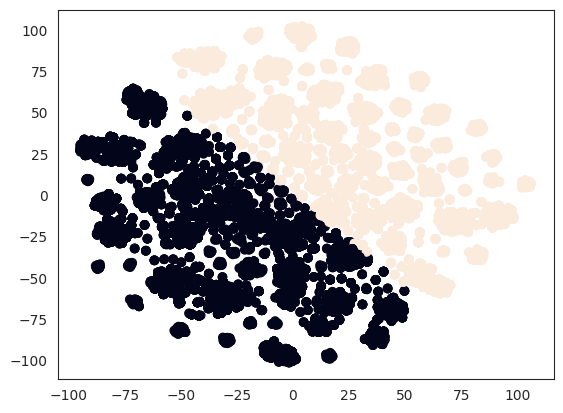

In [ ]:
# Finding the silhouette_score for GMM Cluster value 2
from sklearn.mixture import GaussianMixture
gmm_cluster = GaussianMixture(n_components=2, random_state=123)

# Fit model
clusters = gmm_cluster.fit_predict(tsne_results)


print (f'For GMM cluster number of 2')
print("The silhouette score of the GMM solution: {}"
      .format(metrics.silhouette_score(df_scale, clusters, metric='euclidean')))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=clusters);

For GMM cluster number of 3
The silhouette score of the GMM solution: 0.009597039816686918


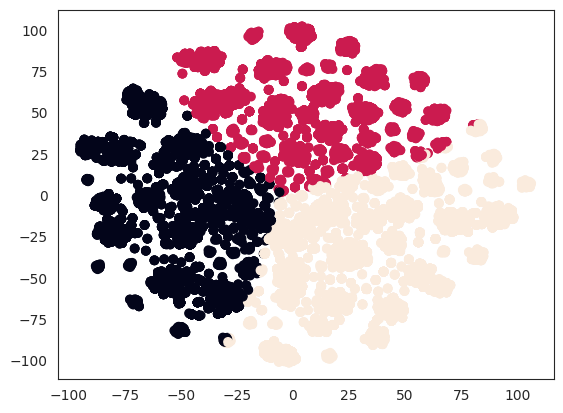

In [ ]:
# Finding the silhouette_score for GMM Cluster value 3
from sklearn.mixture import GaussianMixture
gmm_cluster = GaussianMixture(n_components=3, random_state=123)

# Fit model
clusters = gmm_cluster.fit_predict(tsne_results)


print (f'For GMM cluster number of 3')
print("The silhouette score of the GMM solution: {}"
      .format(metrics.silhouette_score(df_scale, clusters, metric='euclidean')))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=clusters);

For GMM cluster number of 4
The silhouette score of the GMM solution: 0.007014694688126923


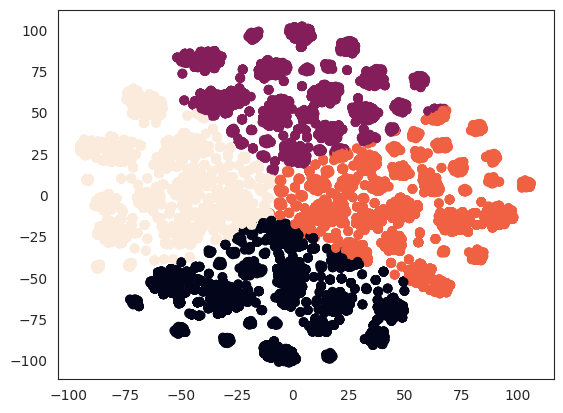

In [ ]:
# Finding the silhouette_score for GMM Cluster value 4
from sklearn.mixture import GaussianMixture
gmm_cluster = GaussianMixture(n_components=4, random_state=123)

# Fit model
clusters = gmm_cluster.fit_predict(tsne_results)


print (f'For GMM cluster number of 4')
print("The silhouette score of the GMM solution: {}"
      .format(metrics.silhouette_score(df_scale, clusters, metric='euclidean')))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=clusters);

For GMM cluster number of 5
The silhouette score of the GMM solution: -0.0668183375761887


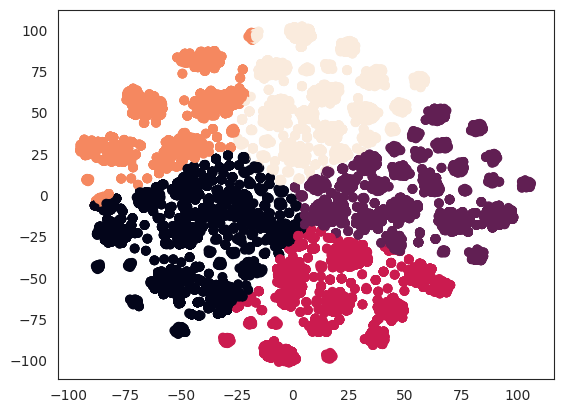

In [ ]:
# Finding the silhouette_score for GMM Cluster value 5
from sklearn.mixture import GaussianMixture
gmm_cluster = GaussianMixture(n_components=5, random_state=123)

# Fit model
clusters = gmm_cluster.fit_predict(tsne_results)


print (f'For GMM cluster number of 5')
print("The silhouette score of the GMM solution: {}"
      .format(metrics.silhouette_score(df_scale, clusters, metric='euclidean')))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=clusters);

For GMM cluster number of 6
The silhouette score of the GMM solution: -0.08682371068535728


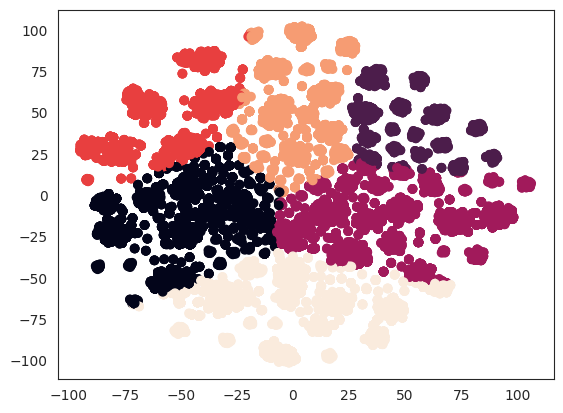

In [ ]:
# Finding the silhouette_score for GMM Cluster value 6
from sklearn.mixture import GaussianMixture
gmm_cluster = GaussianMixture(n_components=6, random_state=123)

# Fit model
clusters = gmm_cluster.fit_predict(tsne_results)


print (f'For GMM cluster number of 6')
print("The silhouette score of the GMM solution: {}"
      .format(metrics.silhouette_score(df_scale, clusters, metric='euclidean')))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=clusters);

Based on the silhouette score, the GMM Cluster value 2 looks better but running with 4 clusters to see more grouping

For GMM cluster number of 4
The silhouette score of the GMM solution: -0.08682371068535728


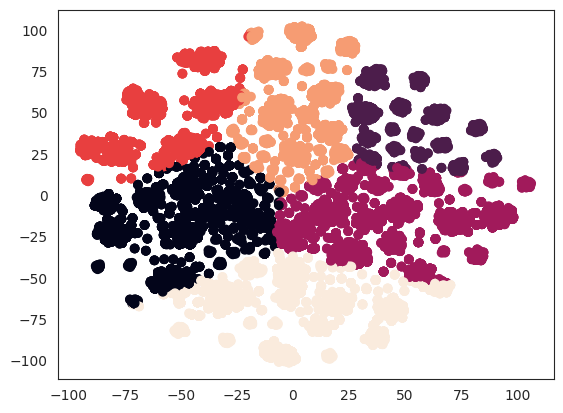

In [ ]:
# Defining the GMM Model
from sklearn.mixture import GaussianMixture
gmm_cluster = GaussianMixture(n_components=4, random_state=123)

# Fit model
gmm_clusters = gmm_cluster.fit_predict(tsne_results)

print (f'For GMM cluster number of 4')
print("The silhouette score of the GMM solution: {}"
      .format(metrics.silhouette_score(df_scale, clusters, metric='euclidean')))

plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=clusters);

**Cluster Analysis of GMM Clusters using t-SNE**

In [ ]:
#Adding the gmm cluster info into the original dataset
uns_final_dataset_gmm['clusters'] = gmm_clusters
uns_final_dataset_gmm['gender'] = final_dataset.gender
uns_final_dataset_gmm['age'] = final_dataset.age
uns_final_dataset_gmm['group'] = final_dataset.group

In [ ]:
#Checking the dataset after adding the cluster info
uns_final_dataset_gmm.head()

,is_installed,is_active,label_id_2,label_id_4,label_id_6,label_id_7,label_id_8,label_id_9,label_id_10,label_id_11,...,group_M22-,group_M23-26,group_M27-28,group_M29-31,group_M32-38,group_M39+,clusters,gender,age,group
0,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,M,19.0,M22-
1,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,M,60.0,M39+
2,1,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,M,28.0,M27-28
3,1,1,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,M,26.0,M23-26
4,1,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,M,22.0,M22-


[Text(0, 0, '6506'),
 Text(0, 0, '5699'),
 Text(0, 0, '5657'),
 Text(0, 0, '5428')]

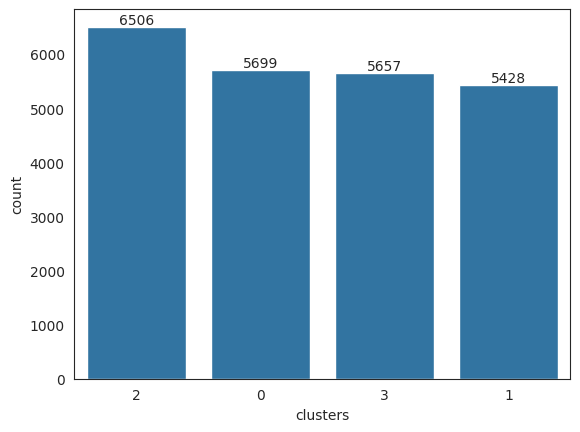

In [ ]:
#Finding the cluster which have more records
ax = sns.countplot(x=uns_final_dataset_gmm['clusters'],
                   order=uns_final_dataset_gmm['clusters'].value_counts(ascending=False).index);

abs_values = uns_final_dataset_gmm['clusters'].value_counts(ascending=False).values

ax.bar_label(container=ax.containers[0], labels=abs_values)

During the time of execution, the cluster 2 have more records

<Axes: xlabel='group', ylabel='count'>

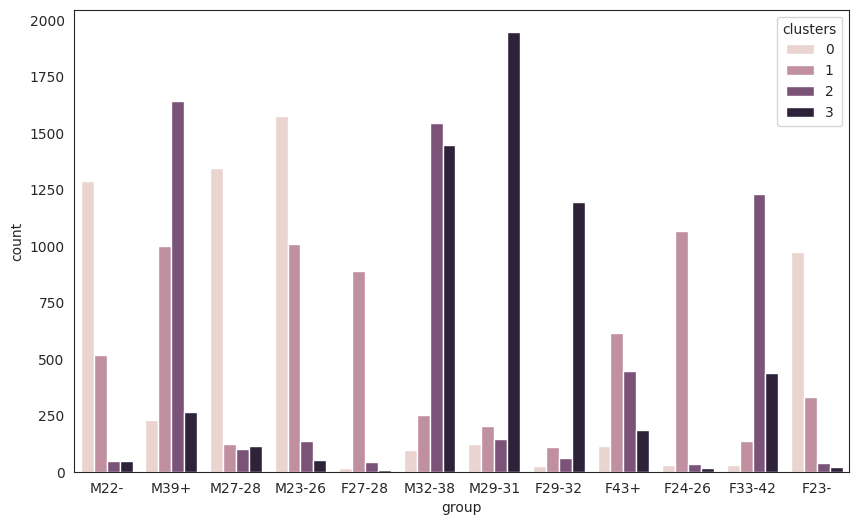

In [ ]:
#Finding the cluster which have most groups
plt.figure(figsize=(10,6))
sns.countplot(x ='group', data = uns_final_dataset_gmm, hue= 'clusters')

During the time of execution,

*   Both Male and Female groups 'M22-','M39+','M27-28','F27-28','M32-38','M29-31','F29-32','F43+','F24-26','F33-42','F23-' are mapped to all the four clusters

# **5.Supervised Learning**


**Feature Selection through Kbest**

Running the Kbest for top 20 best features

In [ ]:
#Running Kbest for 20 top features
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(score_func=f_classif, k=20)

# Fit the selector to your data
selector.fit(X_processed, y)

# Get the indices of the selected features
selected_indices = selector.get_support(indices=True)

# Get the names of the selected features if you have them
selected_feature_names = [X_processed.columns[i] for i in selected_indices]

# Select the top 120 features from your data
X_selected = selector.transform(X_processed)

# If you want to see the scores of the selected features
selected_feature_scores = selector.scores_[selected_indices]

#Print the selected features
print (selected_feature_names)



['is_active', 'age', 'label_id_262', 'label_id_405', 'label_id_549', 'label_id_562', 'label_id_706', 'label_id_713', 'label_id_719', 'label_id_959', 'label_id_1012', 'phone_brand_Huawei', 'phone_brand_Meizu', 'phone_brand_OPPO', 'phone_brand_lshi', 'phone_brand_oneplus', 'phone_brand_samsung', 'phone_brand_vivo', 'gender_F', 'gender_M']


In [ ]:
#Create a dataframe with the new features
X_best_features = pd.DataFrame(X_processed, columns = selected_feature_names).reset_index(drop= True)

#Print information of the dataset
X_best_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40056 entries, 0 to 40055
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   is_active            40056 non-null  float64
 1   age                  40056 non-null  float64
 2   label_id_262         40056 non-null  float64
 3   label_id_405         40056 non-null  float64
 4   label_id_549         40056 non-null  float64
 5   label_id_562         40056 non-null  float64
 6   label_id_706         40056 non-null  float64
 7   label_id_713         40056 non-null  float64
 8   label_id_719         40056 non-null  float64
 9   label_id_959         40056 non-null  float64
 10  label_id_1012        40056 non-null  float64
 11  phone_brand_Huawei   40056 non-null  float64
 12  phone_brand_Meizu    40056 non-null  float64
 13  phone_brand_OPPO     40056 non-null  float64
 14  phone_brand_lshi     40056 non-null  float64
 15  phone_brand_oneplus  40056 non-null 

In [ ]:
#Function to get Classification Report, Confusion Matrix, F1 score and Cross Validation Score

def print_score(clf, X_train, y_train, X_test, y_test):
        pred = clf.predict(X_test)
        #Define the targets
        target_names = ['0.0', '1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0']

        #Print the classification report
        print(('Classification Report: \n {}\n').format(classification_report(y_test, pred,target_names=target_names)))

        #Calculate the confusion matrix
        confusion_rf = confusion_matrix(y_test, pred)

        #Print the confusion matrix
        print(('Confusion Matrix: \n\n {}\n\n').format(confusion_rf))

        #Print the overall accuracy
        print(('Model accuracy Score: {0:.2f} %\n').format(cross_val_score(clf,
                                                                              X_test,
                                                                              y_test, cv=kf).mean()*100))

In [ ]:
#Split the dataset into a training and testing dataset 70/30
X_train_kbest, X_test_kbest, y_train_kbest, y_test_kbest = train_test_split(X_best_features, y,test_size=0.3, random_state=42)

In [ ]:
#Random Forest Classification Model
rf = RandomForestClassifier()

#Tune hyperparameters
#Create range of values to fit parameters
n_estimators_param = np.arange(50,200,50)
max_depth_param = np.arange(1,20,5)

#Fit parameters
parameters = {'n_estimators': n_estimators_param, 'max_depth': max_depth_param}

#Fit parameters using gridsearch
rf = GridSearchCV(rf, param_grid=parameters,  n_jobs = -1, cv=kf, verbose = 1)

#Fit the tunned classifier in the training space
rf.fit(X_train_kbest, y_train_kbest)

#Print the best parameters
print(('Best paramenters Random Forest:\n {}\n').format(rf.best_params_))

#Once the model has been trained test it on the test dataset
rf.fit(X_test_kbest, y_test_kbest)

print_score(rf, X_train_kbest, y_train_kbest, X_test_kbest, y_test_kbest)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best paramenters Random Forest:
 {'max_depth': 16, 'n_estimators': 150}

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Classification Report: 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1017
         1.0       1.00      1.00      1.00      1036
         2.0       1.00      1.00      1.00       973
         3.0       1.00      1.00      1.00       994
         4.0       1.00      1.00      1.00      1015
         5.0       1.00      1.00      1.00       991
         6.0       1.00      1.00      1.00       991
         7.0       1.00      1.00      1.00       985
         8.0       1.00      1.00      1.00       980
         9.0       1.00      1.00      1.00       992
        10.0       1.00      1.00      1.00      1047
        11.0       1.00      0.99      1.00       996

    accuracy                           1.00     12017
   macro avg       1.0

In [ ]:
#Decision Tree Classification Model

dt = DecisionTreeClassifier()

#Tune hyperparameters
#Create range of values to fit parameters

param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : np.arange(1,20,5),
              'criterion' :['gini', 'entropy']
             }

#Fit parameters using gridsearch
dt = GridSearchCV(dt, param_grid=param_grid,  n_jobs = -1, cv=kf, verbose = 1)

#Fit the tunned classifier in the training space
dt.fit(X_train_kbest, y_train_kbest)

#Print the best parameters
print(('Best paramenters Decision Tree Model:\n {}\n').format(dt.best_params_))

#Once the model has been trained test it on the test dataset
dt.fit(X_test_kbest, y_test_kbest)

print_score(dt, X_train_kbest, y_train_kbest, X_test_kbest, y_test_kbest)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best paramenters Decision Tree Model:
 {'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 16, 'max_features': 'sqrt'}

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.99      0.92      0.95      1017
         1.0       0.92      0.99      0.96      1036
         2.0       0.95      0.90      0.92       973
         3.0       0.94      0.87      0.91       994
         4.0       0.83      0.91      0.87      1015
         5.0       0.93      0.96      0.94       991
         6.0       0.99      0.95      0.97       991
         7.0       0.91      0.97      0.94       985
         8.0       0.91      0.93      0.92       980
         9.0       0.96      0.89      0.93       992
        10.0       0.89      0.93      0.91      1047
        11.0       0.90      0.89      0.89       996

    accuracy         

In [ ]:
#KNN Classification Model
from sklearn import neighbors

knn = neighbors.KNeighborsClassifier()

#Tune hyperparameters
#Create range of values to fit parameters

param_grid = { "weights": ["uniform", "distance"],
    "n_neighbors" : np.arange(1,40,5)
             }

#Fit parameters using gridsearch
knn = GridSearchCV(knn, param_grid=param_grid,  n_jobs = -1, cv=kf, verbose = 1)

#Fit the tunned classifier in the training space
knn.fit(X_train_kbest, y_train_kbest)

#Print the best parameters
print(('Best paramenters KNN model:\n {}\n').format(knn.best_params_))

#Once the model has been trained test it on the test dataset
knn.fit(X_test_kbest, y_test_kbest)

print_score(knn, X_train_kbest, y_train_kbest, X_test_kbest, y_test_kbest)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best paramenters KNN model:
 {'n_neighbors': 1, 'weights': 'uniform'}

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Classification Report: 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1017
         1.0       1.00      1.00      1.00      1036
         2.0       1.00      1.00      1.00       973
         3.0       1.00      1.00      1.00       994
         4.0       1.00      1.00      1.00      1015
         5.0       1.00      1.00      1.00       991
         6.0       1.00      1.00      1.00       991
         7.0       1.00      1.00      1.00       985
         8.0       1.00      1.00      1.00       980
         9.0       1.00      1.00      1.00       992
        10.0       1.00      1.00      1.00      1047
        11.0       1.00      1.00      1.00       996

    accuracy                           1.00     12017
   macro avg       1.00 

In [ ]:
#Support Vector Classification Model

svc = SVC()

#Tune hyperparameters
#Create range of values to fit parameters

param_grid = { # "C": [0.001, 0.01, 0.1, 1.],
   "kernel": ["linear", "poly", "rbf", "sigmoid"],
  "gamma": ["scale", "auto"],
             }

#Fit parameters using gridsearch
svc = GridSearchCV(svc, param_grid=param_grid,  n_jobs = -1, cv=kf, verbose = 1)

#Fit the tunned classifier in the training space
svc.fit(X_train_kbest, y_train_kbest)

#Print the best parameters
print(('Best paramenters Support Vector:\n {}\n').format(svc.best_params_))

#Once the model has been trained test it on the test dataset
svc.fit(X_test_kbest, y_test_kbest)

print_score(svc, X_train_kbest, y_train_kbest, X_test_kbest, y_test_kbest)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best paramenters Random Forest:
 {'gamma': 'scale', 'kernel': 'linear'}

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Classification Report: 
               precision    recall  f1-score   support

         0.0       1.00      0.89      0.94      1017
         1.0       0.89      0.85      0.87      1036
         2.0       0.67      0.86      0.76       973
         3.0       0.77      0.79      0.78       994
         4.0       0.82      0.82      0.82      1015
         5.0       0.95      0.83      0.89       991
         6.0       0.96      0.92      0.94       991
         7.0       0.91      0.82      0.86       985
         8.0       0.78      0.86      0.82       980
         9.0       0.82      0.79      0.80       992
        10.0       0.76      0.93      0.84      1047
        11.0       0.97      0.80      0.88       996

    accuracy                           0.85     12017
   macro avg       0.86 

In [ ]:
#Logistic Classification Model
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

#Tune hyperparameters
#Create range of values to fit parameters

param_grid = {  "C": [0.001, 0.01, 0.1, 1.],
    "penalty": ["l1", "l2"]
             }

#Fit parameters using gridsearch
lr = GridSearchCV(lr, param_grid=param_grid,  n_jobs = -1, cv=kf, verbose = 1)

#Fit the tunned classifier in the training space
lr.fit(X_train_kbest, y_train_kbest)

#Print the best parameters
print(('Best paramenters Logistic Classification:\n {}\n').format(lr.best_params_))

#Once the model has been trained test it on the test dataset
lr.fit(X_test_kbest, y_test_kbest)

print_score(lr, X_train_kbest, y_train_kbest, X_test_kbest, y_test_kbest)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best paramenters Logistic Regression:
 {'C': 1.0, 'penalty': 'l2'}

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.97      0.90      0.93      1017
         1.0       0.86      0.95      0.91      1036
         2.0       0.75      0.75      0.75       973
         3.0       0.72      0.70      0.71       994
         4.0       0.70      0.63      0.67      1015
         5.0       0.77      0.84      0.80       991
         6.0       0.94      0.92      0.93       991
         7.0       0.87      0.88      0.88       985
         8.0       0.74      0.78      0.76       980
         9.0       0.70      0.59      0.64       992
        10.0       0.64      0.70      0.67      1047
        11.0       0.81      0.83      0.82       996

    accuracy                           0.79     12017
   macro avg       0.79      

**Feature Selection through PCA**

Running the PCA to get top 10 best features

In [ ]:
#Feature selection through PCA for top 10 features
sklearn_pca = PCA(n_components=10)
X_pca_10 = sklearn_pca.fit_transform(X_processed)
print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.09500412 0.09171669 0.078628   0.06549692 0.05265881 0.05144472
 0.04485807 0.04316279 0.03910033 0.0353056 ]


In [ ]:
#Split our dataset into train and test datasets
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca_10, y,
                                                    test_size=0.33, random_state=42, stratify= y)
print(X_train_pca.shape, y_train_pca.shape)
print(X_test_pca.shape, y_test_pca.shape)

(26837, 10) (26837,)
(13219, 10) (13219,)


In [ ]:
#Random Forest Classification Model
rf_pca = RandomForestClassifier()

#Tune hyperparameters
#Create range of values to fit parameters
n_estimators_param = np.arange(50,200,50)
max_depth_param = np.arange(1,20,5)

#Fit parameters
parameters = {'n_estimators': n_estimators_param, 'max_depth': max_depth_param}

#Fit parameters using gridsearch
rf_pca = GridSearchCV(rf_pca, param_grid=parameters,  n_jobs = -1, cv=kf, verbose = 1)

#Fit the tunned classifier in the training space
rf_pca.fit(X_train_pca, y_train_pca)

#Print the best parameters
print(('Best paramenters Random Forest:\n {}\n').format(rf_pca.best_params_))

#Once the model has been trained test it on the test dataset
rf_pca.fit(X_test_pca, y_test_pca)

print_score(rf_pca, X_train_pca, y_train_pca, X_test_pca, y_test_pca)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best paramenters Random Forest:
 {'max_depth': 16, 'n_estimators': 150}

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Classification Report: 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1101
         1.0       1.00      0.99      1.00      1102
         2.0       1.00      0.98      0.99      1102
         3.0       0.97      0.99      0.98      1102
         4.0       1.00      0.98      0.99      1102
         5.0       0.99      1.00      0.99      1101
         6.0       1.00      1.00      1.00      1102
         7.0       1.00      1.00      1.00      1102
         8.0       1.00      0.99      0.99      1101
         9.0       1.00      0.99      0.99      1101
        10.0       0.98      1.00      0.99      1101
        11.0       0.99      1.00      0.99      1102

    accuracy                           0.99     13219
   macro avg       0.9

In [ ]:
#Decision Tree Classification Model

dt_pca = DecisionTreeClassifier()

#Tune hyperparameters
#Create range of values to fit parameters

param_grid = {'max_features': ['auto', 'sqrt', 'log2'],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : np.arange(1,20,5),
              'criterion' :['gini', 'entropy']
             }

#Fit parameters using gridsearch
dt_pca = GridSearchCV(dt_pca, param_grid=param_grid,  n_jobs = -1, cv=kf, verbose = 1)

#Fit the tunned classifier in the training space
dt_pca.fit(X_train_pca, y_train_pca)

#Print the best parameters
print(('Best paramenters Decision Tree Model:\n {}\n').format(dt_pca.best_params_))

#Once the model has been trained test it on the test dataset
dt_pca.fit(X_test_pca, y_test_pca)

print_score(dt_pca, X_train_pca, y_train_pca, X_test_pca, y_test_pca)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best paramenters Decision Tree Model:
 {'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 16, 'max_features': 'sqrt'}

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.89      0.93      0.91      1101
         1.0       0.86      0.81      0.83      1102
         2.0       0.83      0.82      0.82      1102
         3.0       0.81      0.82      0.82      1102
         4.0       0.91      0.73      0.81      1102
         5.0       0.76      0.94      0.84      1101
         6.0       0.93      0.96      0.94      1102
         7.0       0.88      0.84      0.86      1102
         8.0       0.85      0.80      0.82      1101
         9.0       0.91      0.78      0.84      1101
        10.0       0.81      0.77      0.79      1101
        11.0       0.74      0.93      0.82      1102

    accuracy         

In [ ]:
#KNN Classification Model
from sklearn import neighbors

knn_pca = neighbors.KNeighborsClassifier()

#Tune hyperparameters
#Create range of values to fit parameters

param_grid = { "weights": ["uniform", "distance"],
    "n_neighbors" : np.arange(1,40,5)
             }

#Fit parameters using gridsearch
knn_pca = GridSearchCV(knn_pca, param_grid=param_grid,  n_jobs = -1, cv=kf, verbose = 1)

#Fit the tunned classifier in the training space
knn_pca.fit(X_train_pca, y_train_pca)

#Print the best parameters
print(('Best paramenters KNN model:\n {}\n').format(knn_pca.best_params_))

#Once the model has been trained test it on the test dataset
knn_pca.fit(X_test_pca, y_test_pca)

print_score(knn_pca, X_train_pca, y_train_pca, X_test_pca, y_test_pca)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best paramenters KNN model:
 {'n_neighbors': 1, 'weights': 'uniform'}

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Classification Report: 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1101
         1.0       1.00      1.00      1.00      1102
         2.0       1.00      1.00      1.00      1102
         3.0       1.00      1.00      1.00      1102
         4.0       1.00      1.00      1.00      1102
         5.0       1.00      1.00      1.00      1101
         6.0       1.00      1.00      1.00      1102
         7.0       1.00      1.00      1.00      1102
         8.0       1.00      1.00      1.00      1101
         9.0       1.00      1.00      1.00      1101
        10.0       1.00      1.00      1.00      1101
        11.0       1.00      1.00      1.00      1102

    accuracy                           1.00     13219
   macro avg       1.00 

In [ ]:
#Support Vector Classification Model

svc_pca = SVC()

#Tune hyperparameters
#Create range of values to fit parameters

param_grid = { # "C": [0.001, 0.01, 0.1, 1.],
   "kernel": ["linear", "poly", "rbf", "sigmoid"],
  "gamma": ["scale", "auto"],
             }

#Fit parameters using gridsearch
svc_pca = GridSearchCV(svc_pca, param_grid=param_grid,  n_jobs = -1, cv=kf, verbose = 1)

#Fit the tunned classifier in the training space
svc_pca.fit(X_train_pca, y_train_pca)

#Print the best parameters
print(('Best paramenters Support Vector:\n {}\n').format(svc_pca.best_params_))

#Once the model has been trained test it on the test dataset
svc_pca.fit(X_test_pca, y_test_pca)

print_score(svc_pca, X_train_pca, y_train_pca, X_test_pca, y_test_pca)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best paramenters Support Vector:
 {'gamma': 'scale', 'kernel': 'rbf'}

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.94      0.87      0.90      1101
         1.0       0.74      0.79      0.76      1102
         2.0       0.61      0.70      0.65      1102
         3.0       0.61      0.59      0.60      1102
         4.0       0.66      0.61      0.63      1102
         5.0       0.88      0.85      0.86      1101
         6.0       0.93      0.92      0.92      1102
         7.0       0.82      0.79      0.80      1102
         8.0       0.68      0.71      0.69      1101
         9.0       0.62      0.62      0.62      1101
        10.0       0.63      0.71      0.67      1101
        11.0       0.92      0.83      0.87      1102

    accuracy                           0.75     13219
   macro avg       0.75   

In [ ]:
#Logistic Classification Model
from sklearn.linear_model import LogisticRegression

lr_pca = LogisticRegression()

#Tune hyperparameters
#Create range of values to fit parameters

param_grid = {  "C": [0.001, 0.01, 0.1, 1.],
    "penalty": ["l1", "l2"]
             }

#Fit parameters using gridsearch
lr_pca = GridSearchCV(lr_pca, param_grid=param_grid,  n_jobs = -1, cv=kf, verbose = 1)

#Fit the tunned classifier in the training space
lr_pca.fit(X_train_pca, y_train_pca)

#Print the best parameters
print(('Best paramenters Logistic Classification:\n {}\n').format(lr_pca.best_params_))

#Once the model has been trained test it on the test dataset
lr_pca.fit(X_test_pca, y_test_pca)

lr_pca_predit = lr_pca.predict(X_test_pca)

print_score(lr_pca, X_train_pca, y_train_pca, X_test_pca, y_test_pca)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best paramenters Logistic Regression:
 {'C': 1.0, 'penalty': 'l2'}

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Classification Report: 
               precision    recall  f1-score   support

         0.0       0.83      0.85      0.84      1101
         1.0       0.58      0.62      0.60      1102
         2.0       0.46      0.52      0.48      1102
         3.0       0.37      0.31      0.34      1102
         4.0       0.42      0.36      0.39      1102
         5.0       0.62      0.66      0.64      1101
         6.0       0.84      0.85      0.85      1102
         7.0       0.65      0.70      0.68      1102
         8.0       0.47      0.48      0.47      1101
         9.0       0.47      0.36      0.41      1101
        10.0       0.39      0.39      0.39      1101
        11.0       0.62      0.69      0.65      1102

    accuracy                           0.57     13219
   macro avg       0.56      

Comparing the Predictions of models based on Kbest Approach

In [ ]:
predictions_dictionary_kbest = {'Actual': y_test_kbest,'Logistic Classification_Kbest' : lr.predict(X_test_kbest),
                          'KNN_Kbest' : knn.predict(X_test_kbest),
                          'SVC_Kbest' : svc.predict(X_test_kbest), 'Decision Tree_Kbest' : dt.predict(X_test_kbest) ,
                          'Random Forest_Kbest' : rf.predict(X_test_kbest)}

predictions_df_kbest = pd.DataFrame(predictions_dictionary_kbest)
predictions_df_kbest

,Actual,Logistic Regression_Kbest,KNN_Kbest,SVC_Kbest,Decision Tree_Kbest,Random Forest_Kbest
22397,3,4,3,2,3,3
7251,4,4,4,4,4,4
20258,3,3,3,3,3,3
32271,6,6,6,6,6,6
19387,7,7,7,7,7,7
...,...,...,...,...,...,...
563,1,1,1,1,1,1
18552,7,6,7,7,7,7
25383,8,8,8,8,8,8
32897,6,6,6,6,6,6


Comparing the Predictions of models based on PCA Approach

In [ ]:
predictions_dictionary_pca = {'Actual': y_test_pca,'Logistic Classification_pca' : lr_pca.predict(X_test_pca),
                          'KNN_pca' : knn_pca.predict(X_test_pca),
                          'SVC_pca' : svc_pca.predict(X_test_pca), 'Decision Tree_pca' : dt_pca.predict(X_test_pca) ,
                          'Random Forest_pca' : rf_pca.predict(X_test_pca)}

predictions_df_pca = pd.DataFrame(predictions_dictionary_pca)
predictions_df_pca

,Actual,Logistic Regression_pca,KNN_pca,SVC_pca,Decision Tree_pca,Random Forest_pca
34349,10,10,10,10,10,10
10386,2,2,2,2,2,2
11783,2,2,2,2,2,2
15662,5,5,5,5,5,5
22398,3,3,3,3,3,3
...,...,...,...,...,...,...
21820,3,3,3,3,3,3
8053,4,4,4,2,4,4
17728,7,7,7,7,7,7
27825,11,11,11,11,11,11


**Supervised Learning Models Accuarcy**

Model Accuracy through Kbest Approach (Top 20 Features):

1.   Logistic Classification - **74%** {'C': 1.0, 'penalty': 'l2'}
2.   KNN Classification - **91%** {'n_neighbors': 1, 'weights': 'uniform'}
3.   Decision Tree - **86%** {'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 16, 'max_features': 'sqrt'}
4.   Support Vector Classification - **81%** {'gamma': 'scale', 'kernel': 'linear'}
5.   Random Forest - **97%** {'max_depth': 16, 'n_estimators': 150}

Model Accuracy through PCA:

1.   Logistic Classification - **54**% {'C': 1.0, 'penalty': 'l2'}
2.   KNN Classification - **92**% {'n_neighbors': 1, 'weights': 'uniform'}
3.   Decision Tree - **80**% {'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 16, 'max_features': 'sqrt'}
4.   Support Vector Classification - **69**% {'gamma': 'scale', 'kernel': 'rbf'}
5.   Random Forest - **92**% {'max_depth': 16, 'n_estimators': 150}

# **6.Conclusion**

The purpose of this product is to classify a subset of the population of China that uses a mobile operator based on the apps they have installed and that they used and the brand of the device they have. The classification takes into consideration gender and age range. The groups are distributed as follows (M=male, F=female being digits age limits): 'M39+' , 'M32-38', 'M29-31', 'M27-28', 'M23-26', 'M22-', 'F43+' ,'F33-42', 'F29-32', 'F27-28', 'F24-26', 'F23-'.

**Exploratory data analysis:**

*   Number of apps active is roughly 50% of the apps installed
*   Population is concentrated in a range between 20 and 32 and that the age distribution
*   From an apps perspective, most of them have to do with financial products, banking and industrial (construction)
*   From a brand perspective eight brands represent 90% of the sample in the Chinese market (Xaomi, Samsung, Huawei, Vivo, OPPO, Meizu, Coldpad y Lenovo)
*   There is inequality in terms of gender distribution being the female users half the male users
*   The different groups are unbalanced therefore resampling of the data has been done to avoid bias on the different classifiers that are used

**Model Performance**

Model selection has been carried out splitting the sample into 70/30 training on 70% of the data. Models have been trained and tuned using gridsearch and cross validation with five folds has been used to test them.

**Supervised Learning Models:**

Model Accuracy through Kbest Approach (Top 20 Features):

*   Logistic Classification - 74% {'C': 1.0, 'penalty': 'l2'}
*   KNN Classification - 91% {'n_neighbors': 1, 'weights': 'uniform'}
*   Decision Tree - 86% {'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 16, 'max_features': 'sqrt'}
*   Support Vector Classification - 81% {'gamma': 'scale', 'kernel': 'linear'}
*   Random Forest - 97% {'max_depth': 16, 'n_estimators': 150}

Model Accuracy through PCA:

*   Logistic Classification - 54% {'C': 1.0, 'penalty': 'l2'}
*   KNN Classification - 92% {'n_neighbors': 1, 'weights': 'uniform'}
*   Decision Tree - 80% {'ccp_alpha': 0.001, 'criterion': 'entropy', 'max_depth': 16, 'max_features': 'sqrt'}
*   Support Vector Classification - 69% {'gamma': 'scale', 'kernel': 'rbf'}
*   Random Forest - 92% {'max_depth': 16, 'n_estimators': 150}

**Deep Learning Models**

*   ANN Model Accuracy - 78.3% (6 Dense Layers, Ranging from 264 t0 12 neurons, 40 epoch, 128 batch size,loss='categorical_crossentropy',optimizer= 'sgd')
*   CNN Model Accuracy - 48.6% (1 Convolutional layer, 1 Dense layer, 40 epoch, 128 batch size, loss="mse", optimizer="adam")


**Hence, from a classification purpose the best model to use based on its accuracy is Random Forest which can compete in terms of accuracy with deep learning models but is a better candidate for production**
